<font color='turquoise'><font size='5'>**Workplace Project:** Forecasting the returns of a portfolio of 2 shares, taking into account their dependency structure</font>

<font color='turquoise'><font size='4'>**Introduction**</font>

In this notebook, we explore how to forecast the riskiness inherent from a portfolio constituting of two shares using a blend of statistical models and methods. We take into consideration the inherent patterns in each share data time series as well as the dependence structure between the two.

When it comes to predicting share prices, a blend of statistical techniques can help capture different aspects of market behavior. ARIMA (AutoRegressive Integrated Moving Average) models are great for capturing time series data's linear patterns and trends. They help predict future values based on past data, handling trends and seasonality.

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models extend this by focusing on volatility. They help in understanding and forecasting the fluctuating variance, making them crucial for financial data where volatility clustering is common.

Lastly, Copulas bring in the power of dependency structures, allowing us to model and simulate the joint distribution of multiple financial assets. This is key for portfolio management and risk assessment, where the relationships between assets need to be understood and modeled.

Combining these methods gives a robust framework for understanding and predicting share prices, capturing trends, volatility, and dependencies. Some real life applications of the model are also provided.

For the purpose of this project we are using data for Apple Inc. and Nvidia Corporation.

This notebook is structured as follows:
* [Importing the required packages](#another_cell1)
* [Importing and Filtering the data](#another_cell2)
* [Data Cleaning and Exploratory Data Analysis (EDA)](#another_cell3)
* [Further Analysis and Visualisations](#another_cell4)
* [Modeling and Forecasting](#another_cell5)
* [Practical Applications](#another_cell6)
* [Conclusion](#another_cell7)
* [References](#another_cell8)


<a id='another_cell1'></a>

<font color='turquoise'><font size='4'>**Importing the required packages**</font>

Let's begin by importing the required Python packages.


In [27]:
# Install sktime and all its dependencies first
!pip install sktime[all_extras]
# Install arch
!pip install sktime arch

# Install specific versions of numpy, pandas
!pip install numpy==2.2.1 pandas==2.2.2

# Install and update pmdarima
!pip install --upgrade --no-binary pmdarima pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.2.1 which is incompatible.
u8darts 0.31.0 requires numpy<2.0.0,>=1.19.0, but you have numpy 2.2.1 which is incompatible.
gluonts 0.16.0 requires numpy<2.2,>=1.16, but you have numpy 2.2.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.1 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.16.2 which is incompatible.
jax 0.5.

In [100]:
# Import the rest of the packages
# The import process has been split into 2 as importing sktime and all its dependencies is time consuming
import pandas as pd
import numpy as np # Importing the numpy package with an alias, np
import scipy.stats as stats
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.cm as cm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
import seaborn as sns
from scipy.stats import norm, multivariate_normal, t
from IPython.display import Image
from graphviz import Digraph


sns.set_theme(style="whitegrid") # Set the seaborn colour theme

Export the current environment for reproduceability.

In [29]:
# Export the packages/requirements
!pip freeze > requirements.txt

<font color='turquoise'><font size='4'>**Importing and Filtering the data**</font> <a id='another_cell2'></a>

<font size='4'>**Importing the data**</font>


We can then proceed with importing the data from Yahoo Finance using the yfinance package. For the purpose of this project we are using data for Apple Inc. and Nvidia Corporation which are both quoted on the NASDAQ stock exchange and with tickers 'AAPL' and 'NVDA' respectively.

Both companies operate in the technology field and intuitively, we expect that they should be influenced by similar factors.

For instance, rise in the price of raw materials such as copper which are important in circuitry, changes in regulations for technology and so on. Bearing this in mind, we already expect some degree of positive dependence between the two.

In [30]:
# Download stock data for NVIDIA and Apple (Both "daily" as specfied by the interval)
data = yf.download(['NVDA', 'AAPL'], start='2000-01-01', end='2024-10-14', interval='1d')

# Display the first few rows of the initial DataFrame
data.head()

[*********************100%***********************]  2 of 2 completed


Price          Close                High                 Low            \
Ticker          AAPL      NVDA      AAPL      NVDA      AAPL      NVDA   
Date                                                                     
2000-01-03  0.842151  0.089431  0.846382  0.090984  0.765036  0.084297   
2000-01-04  0.771149  0.087044  0.832276  0.088118  0.761274  0.082625   
2000-01-05  0.782433  0.084178  0.831806  0.085969  0.774910  0.082984   
2000-01-06  0.714723  0.078685  0.805004  0.084178  0.714723  0.075462   
2000-01-07  0.748578  0.079999  0.759864  0.080835  0.718485  0.077134   

Price           Open               Volume             
Ticker          AAPL      NVDA       AAPL       NVDA  
Date                                                  
2000-01-03  0.789017  0.090268  535796800  300912000  
2000-01-04  0.814408  0.087879  512377600  300480000  
2000-01-05  0.780552  0.084536  778321600  188352000  
2000-01-06  0.798421  0.084178  767972800  120480000  
2000-01-07  0.726008  0.078327  460734400   71184000

In [31]:
# Display the last few rows of the initial DataFrame
data.tail()

Price            Close                    High                     Low  \
Ticker            AAPL        NVDA        AAPL        NVDA        AAPL   
Date                                                                     
2024-10-07  221.203156  127.699455  225.194371  130.618984  220.843945   
2024-10-08  225.274200  132.868622  225.483731  133.458523  222.759730   
2024-10-09  229.035919  132.628662  229.245465  134.498372  224.336271   
2024-10-10  228.537018  134.788315  228.996014  134.978287  226.671129   
2024-10-11  227.050293  134.778320  228.906209  135.758158  226.840747   

Price                         Open                Volume             
Ticker            NVDA        AAPL        NVDA      AAPL       NVDA  
Date                                                                 
2024-10-07  124.929897  224.006982  124.969891  39505400  346250200  
2024-10-08  129.399179  223.807427  130.239040  31855700  285722500  
2024-10-09  131.358877  224.735386  134.088434  33591100  246191600  
2024-10-10  130.978930  227.279790  131.888787  28183500  242311300  
2024-10-11  133.638504  228.796450  133.988439  31759200  170209500

The data consists of:
* <i>Date</i> which is the trading date.
* <i>Adj Close</i> and <i>Close </i> both represent the final price at which a share is traded at the end of a trading day. <i>Adj Close</i> (Adjusted Close) however adjusts the closing price to reflect events like dividends, stock splits, and new offerings.
* <i> High </i> and <i> Low </i> are the highest and lowest prices the shares have reached that particular trading day.
* <i>Opening</i> represents the opening price at which a share is traded at the end of a trading day.
* <i>Volume</i> refers to the number of shares traded over that particular trading day.
Except for <i>Date</i>, each of the data fields is available for each of Apple and Nvidia.

For the purpose of our analysis, we will be using <i>Close </i>.











<font size='4'>**Filtering the data**</font>

Let us first proceed with visualising the data. Below is depicted the price evolution, across time, of the two shares.

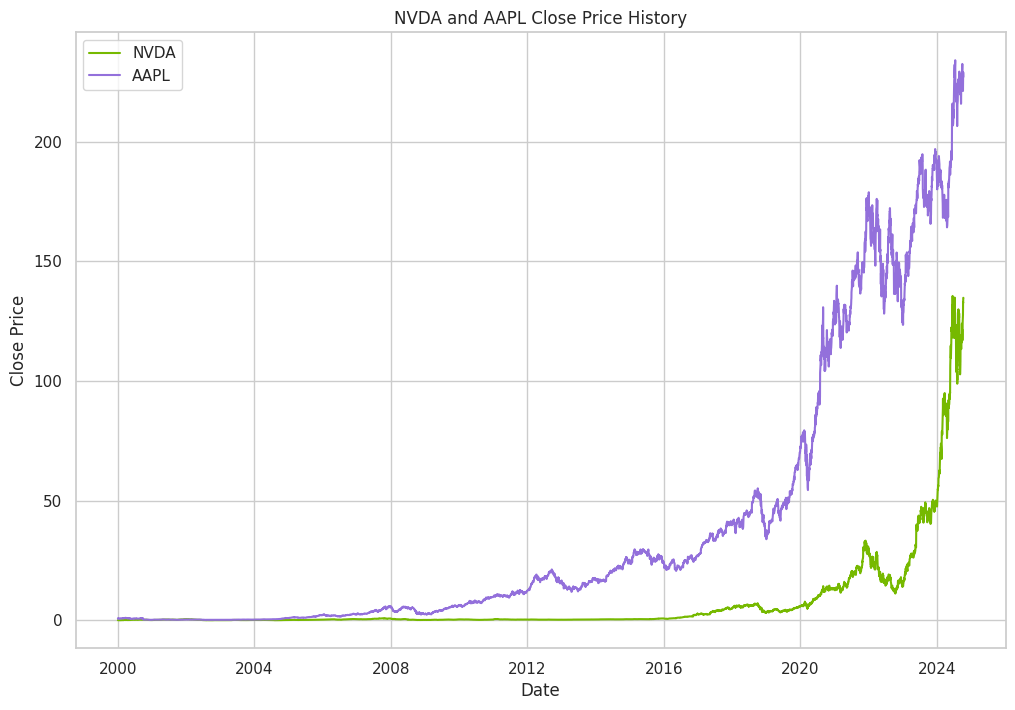

In [32]:
# Plot the close price history

# Define colours for ease of reference
# NVDA green logo color (approx)
nvda_logo_color = '#76B900'
# Bright purple color for Apple
aapl_bright_color = 'mediumpurple'


plt.figure(figsize=(12, 8))

# Plot NVDA Close Price history
plt.plot(data.index, data['Close']['NVDA'], label='NVDA', color= nvda_logo_color)

# Plot AAPL Close Price history
plt.plot(data.index, data['Close']['AAPL'], label='AAPL', color= aapl_bright_color)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('NVDA and AAPL Close Price History')
plt.legend()
plt.grid(True)
plt.show()

The graph shows that the growth of Apple's share price is somewhat linear over the around 2009 to 2015 before it grows at a more exponential rate.

For Nvidia this exponential growth is seen as from around 2021.

A few need to be considered before proceeding further:
* The data includes extreme events happening such as the dot-com bubble crisis which peaked in March 2020, the great financial crisis which occured in 2007-2008 and the more recent covid pandemic period.
* Using data which is too far back in the past might not to be relevant for forecasting as trends might have changed; there is always the questions of: "how much data is sufficient and how much is too much?". These questions are particularly relevant for technology companies where the rate of change in the operating environment is very fast and recent growth has been massive.

As such, we will use data spanning from start of 2015 to mid October 2024, roughly 10 years of data for analysis which should be sufficient but also not too far back.

In [33]:
# Ensure Date is a column
data.reset_index(inplace=True)

# Filter based on dates
mask = (data['Date'] >= '2015-01-01') & (data['Date'] <= '2024-10-15')
filtered_data = data.loc[mask].copy()

# Display the filtered DataFrame
filtered_data.head()

Price        Date      Close                 High                  Low  \
Ticker                  AAPL      NVDA       AAPL      NVDA       AAPL   
3773   2015-01-02  24.320429  0.483099  24.789798  0.486699  23.879978   
3774   2015-01-05  23.635286  0.474939  24.169166  0.484539  23.448429   
3775   2015-01-06  23.637512  0.460540  23.897778  0.476139  23.274918   
3776   2015-01-07  23.968960  0.459340  24.069062  0.467980  23.735387   
3777   2015-01-08  24.889908  0.476619  24.947745  0.479499  24.180292   

Price                  Open               Volume             
Ticker      NVDA       AAPL      NVDA       AAPL       NVDA  
3773    0.475419  24.778675  0.483099  212818400  113680000  
3774    0.472780  24.089084  0.483099  257142000  197952000  
3775    0.460060  23.699798  0.475659  263188400  197764000  
3776    0.457900  23.846612  0.463900  160423600  321808000  
3777    0.464380  24.298192  0.464620  237458000  283780000

<font size='4'>**Creating log returns**</font>

To implement the ARIMA and GARCH models, we calculate the log returns (log to base <i>e </i>) of the data. These are more statistically robust than simple returns. They help in stabilising the variance and normalising the data, making the time series more suitable for model assumptions. This helps ARIMA capture linear relationships and trends more effectively, while GARCH can more accurately model volatility clustering.

**To note that this step has been implemented before the data cleanup as we would also like to investigate any abnormally large values in the log returns.**

In [34]:
# Calculate log returns
filtered_data['NVDA_log_return'] = np.log(filtered_data['Close']['NVDA'] / filtered_data['Close']['NVDA'].shift(1))
filtered_data['AAPL_log_return'] = np.log(filtered_data['Close']['AAPL'] / filtered_data['Close']['AAPL'].shift(1))

# Drop the first row as first value of log returns will be NaN
filtered_data = filtered_data.drop(filtered_data.index[0])

# Display the DataFrame with log returns
print(filtered_data.head())

Price        Date      Close                 High                  Low  \
Ticker                  AAPL      NVDA       AAPL      NVDA       AAPL   
3774   2015-01-05  23.635286  0.474939  24.169166  0.484539  23.448429   
3775   2015-01-06  23.637512  0.460540  23.897778  0.476139  23.274918   
3776   2015-01-07  23.968960  0.459340  24.069062  0.467980  23.735387   
3777   2015-01-08  24.889908  0.476619  24.947745  0.479499  24.180292   
3778   2015-01-09  24.916599  0.478539  25.192437  0.482139  24.516189   

Price                  Open               Volume            NVDA_log_return  \
Ticker      NVDA       AAPL      NVDA       AAPL       NVDA                   
3774    0.472780  24.089084  0.483099  257142000  197952000       -0.017034   
3775    0.460060  23.699798  0.475659  263188400  197764000       -0.030787   
3776    0.457900  23.846612  0.463900  160423600  321808000       -0.002609   
3777    0.464380  24.298192  0.464620  237458000  283780000        0.036927   
3778   

<a id='another_cell3'></a>

<font color='turquoise'><font size='4'>**Data Cleaning & Exploratory Data Analysis (EDA)**</font>

<font size='4'>**Data Cleaning**</font>

The data is exported to excel for more in depth data checks.

In [35]:
# Export to Excel
# Convert 'Date' column to timezone-naive datetime objects which excel supports
filtered_data_v2 = filtered_data.copy()
filtered_data_v2['Date'] = filtered_data['Date'].dt.tz_localize(None)

#Now export the updated DataFrame
filtered_data_v2.to_excel('data.xlsx', index=True)

A battery of checks were performed in excel. The main issue found was that the data was missing 22 trading days which was not explainable. This was after excluding weekends and public holidays (where no trading is expected). Given that this number is **[1]** low compared to the overall number of data points (less than 1%) and **[2]** that they are not consecutive, decision has been taken to ignore this error as it is deemed to have little material impact.

<font size='4'>**Exploratory Data Analysis (EDA)**</font>

We start by checking the summary statistics of the data.

In [36]:
filtered_data.describe()

Price                            Date        Close                      High  \
Ticker                                        AAPL         NVDA         AAPL   
count                            2460  2460.000000  2460.000000  2460.000000   
mean    2019-11-22 14:34:32.195121920    91.019174    18.141938    91.921855   
min               2015-01-05 00:00:00    20.674534     0.459340    20.978908   
25%               2017-06-13 18:00:00    34.757853     3.419186    35.031317   
50%               2019-11-20 12:00:00    61.730310     6.272182    62.419183   
75%               2022-05-02 06:00:00   147.881504    19.865770   149.150534   
max               2024-10-11 00:00:00   234.033447   135.546600   236.435360   
std                               NaN    62.773240    27.296772    63.381905   

Price                        Low                      Open               \
Ticker         NVDA         AAPL         NVDA         AAPL         NVDA   
count   2460.000000  2460.000000  2460.000000  2460.000000  2460.000000   
mean      18.476522    90.027548    17.770413    90.946443    18.135295   
min        0.467980    20.475433     0.454540    20.596724     0.463660   
25%        3.480947    34.341462     3.360993    34.590046     3.403013   
50%        6.360119    60.163289     6.187011    60.869960     6.266841   
75%       20.155254   145.978105    19.427121   147.419807    19.847344   
max      140.725309   232.309228   133.638504   235.687872   139.765554   
std       27.833621    62.096875    26.701774    62.721636    27.302161   

Price         Volume               NVDA_log_return AAPL_log_return  
Ticker          AAPL          NVDA                                  
count   2.460000e+03  2.460000e+03     2460.000000     2460.000000  
mean    1.186624e+08  4.734196e+08        0.002289        0.000908  
min     2.404830e+07  5.244800e+07       -0.207712       -0.137708  
25%     7.340735e+07  3.120010e+08       -0.012405       -0.007446  
50%     1.017478e+08  4.215930e+08        0.002630        0.000942  
75%     1.433835e+08  5.675970e+08        0.017453        0.010097  
max     6.488252e+08  3.692928e+09        0.260876        0.113158  
std     6.822781e+07  2.533862e+08        0.030518        0.018066

Observations:
* The maximum and minimum log returns for each share price are reasonable. To note that for AAPL, the maximum/minimum returns happened during the period where the covid pandemic was still ongoing, which might suggest there was higher volatility in share prices then. For NVDA, the maximum return was in  November 2016 which coincided with: "record revenue, record margins and record earnings were driven by strength across all product lines". The minimum return coincides with the period where share price plunged as the demand for GPUs (Graphical Processing Units, one of NVDA's main products) fell. These were used to mine crypto-currencies and when the value of these fell in 2018, so did the demand for GPUs.

**To note that the dates for same were derived in the accompanying excel workbook which contains the checks made.**

* The mean log returns were around zero.

We now proceed with comparing the log returns with white noise data to see if it exhibits volatility clustering; prolonged periods where the returns fluctuate a lot and prolonged periods where this is little fluctuation.

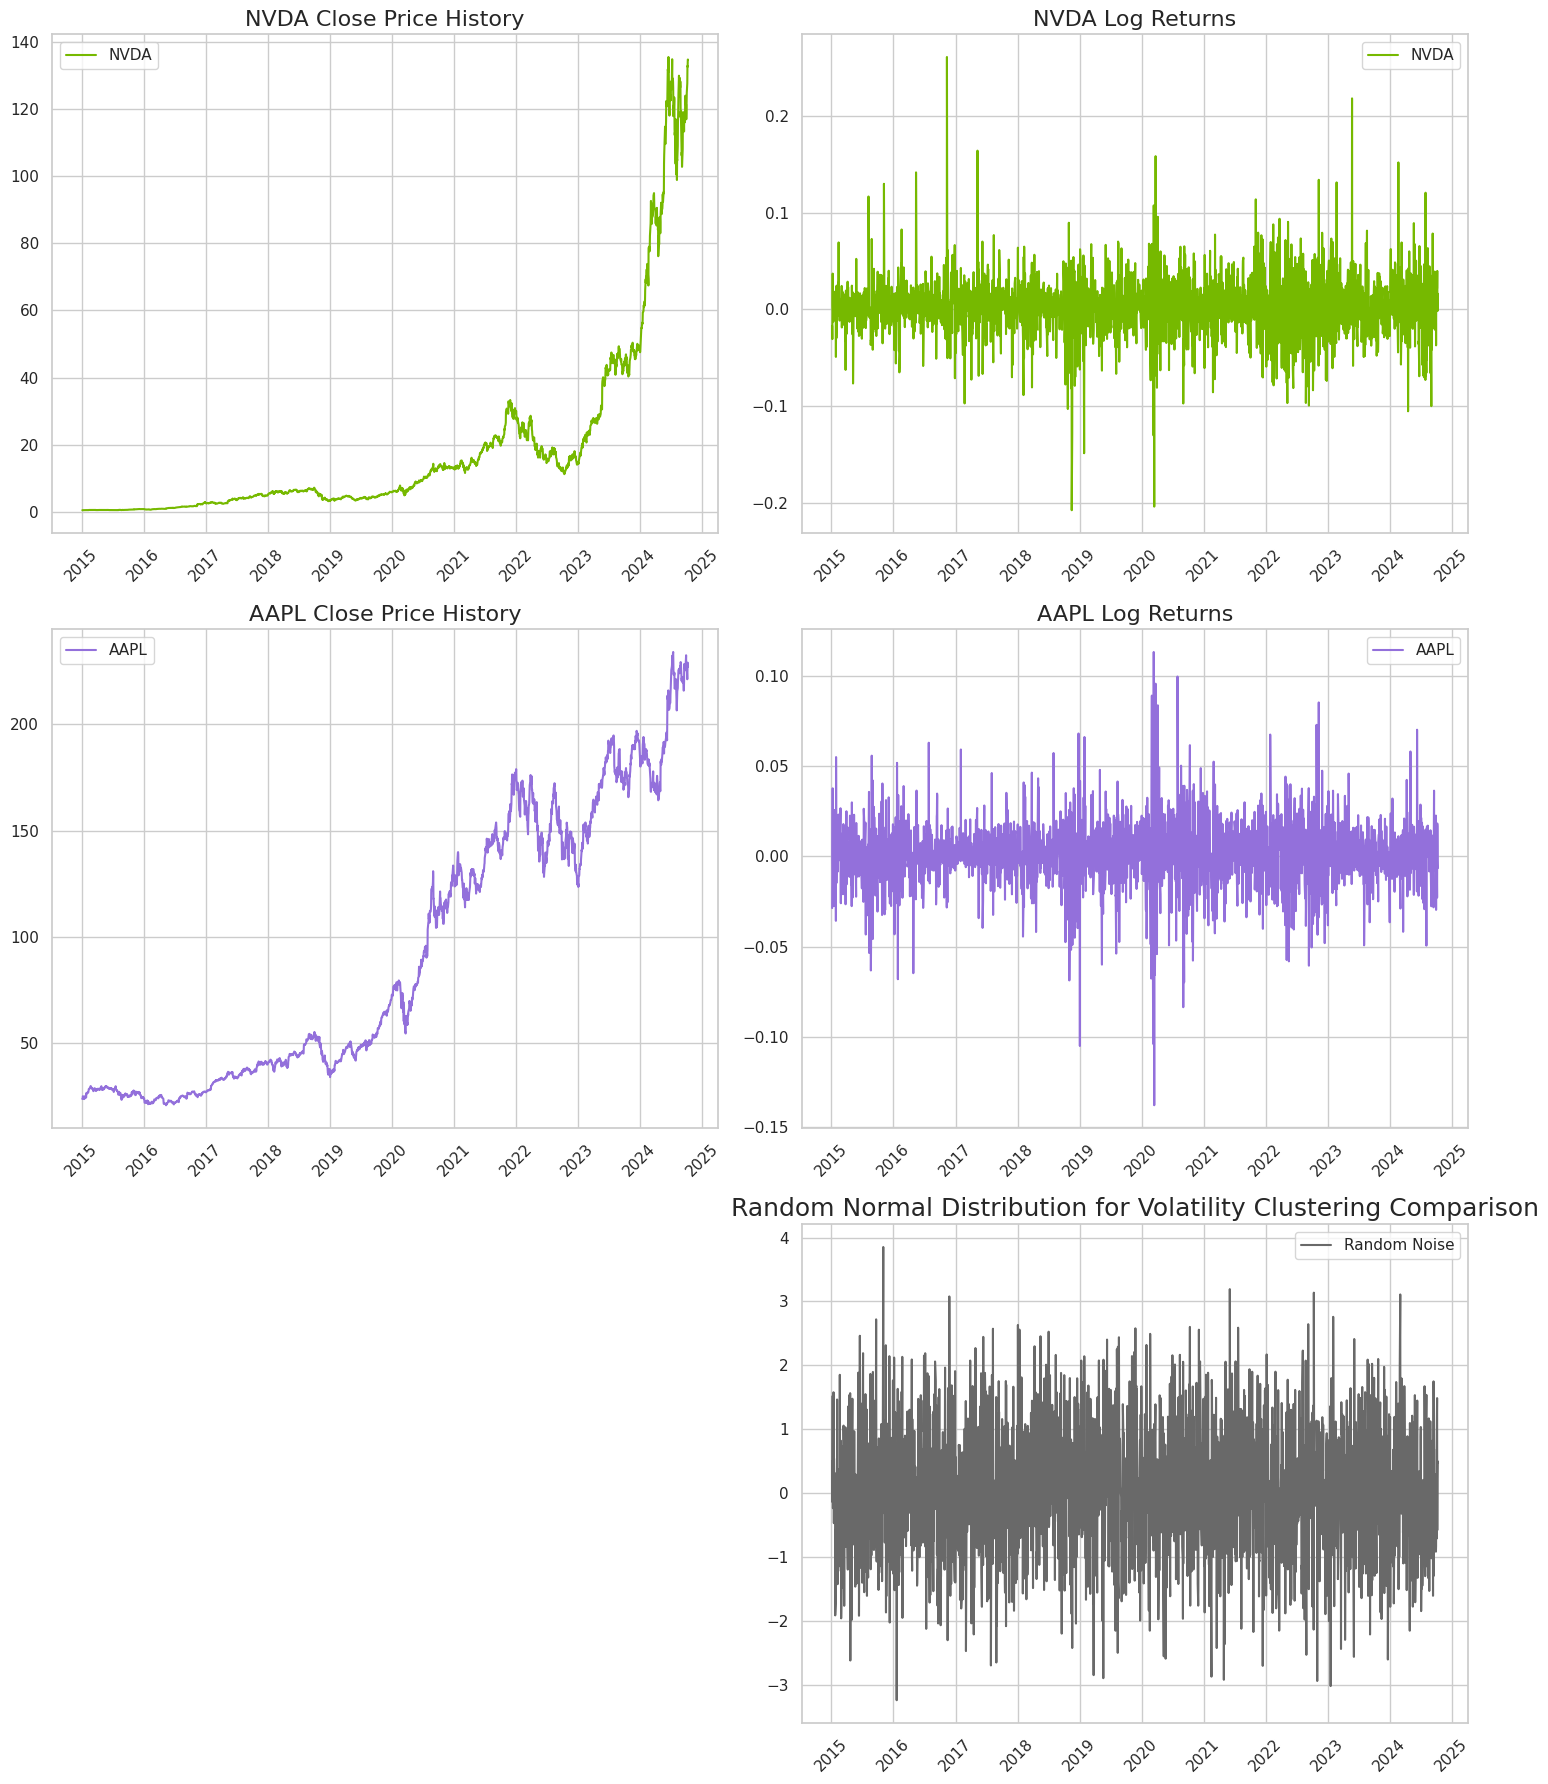

In [37]:
# Create subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

# NVDA Close Price history
ax[0, 0].plot(filtered_data['Date'], filtered_data['Close']['NVDA'], label='NVDA', color= nvda_logo_color)
ax[0, 0].set_title('NVDA Close Price History', size=16)
ax[0, 0].legend()
ax[0, 0].tick_params(axis='x', rotation=45)

# NVDA log returns
ax[0, 1].plot(filtered_data['Date'], filtered_data['NVDA_log_return'], label='NVDA', color= nvda_logo_color)
ax[0, 1].set_title('NVDA Log Returns', size=16)
ax[0, 1].legend()
ax[0, 1].tick_params(axis='x', rotation=45)

# AAPL Close Price history
ax[1, 0].plot(filtered_data['Date'], filtered_data['Close']['AAPL'], label='AAPL', color=aapl_bright_color)
ax[1, 0].set_title('AAPL Close Price History', size=16)
ax[1, 0].legend()
ax[1, 0].tick_params(axis='x', rotation=45)

# AAPL log returns
ax[1, 1].plot(filtered_data['Date'], filtered_data['AAPL_log_return'], label='AAPL', color=aapl_bright_color)
ax[1, 1].set_title('AAPL Log Returns', size=16)
ax[1, 1].legend()
ax[1, 1].tick_params(axis='x', rotation=45)

# Add random normal distribution (white noise)
# Setting the seed for reproducibility
np.random.seed(42)
random_noise = np.random.normal(0, 1, len(filtered_data))
ax[2, 1].plot(filtered_data['Date'], random_noise, label='Random Noise', color='dimgray')
ax[2, 1].set_title('Random Normal Distribution for Volatility Clustering Comparison',size=18)
ax[2, 1].legend()
ax[2, 1].tick_params(axis='x', rotation=45)

# Hide empty subplot
fig.delaxes(ax[2,0])
plt.tight_layout()

plt.show()

The data shows volatility clustering; in 2020, both AAPL and NVDA had higher fluctuations in their log returns.

For the random noise series, there is no discernable pattern. This shows that the log returns would be a suitable candidate for GARCH models.

We then move on to Kernel Density Estimation (KDE) and pairwise correlation plots for the data.



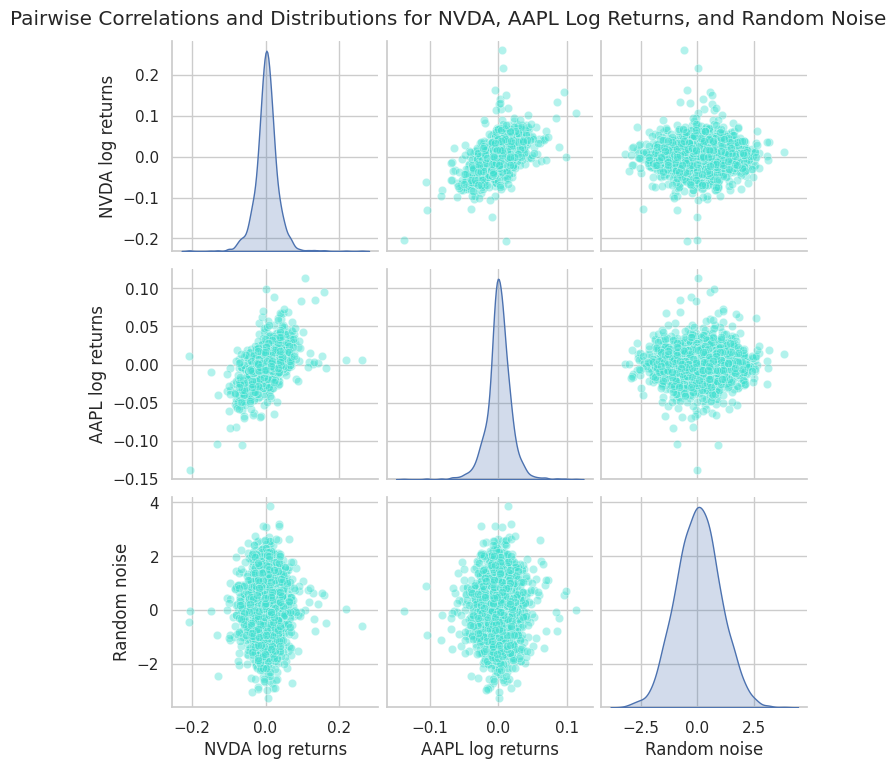

In [38]:
# Set theme for better visuals
sns.set_theme(style="whitegrid")

# Construct DataFrame with the relevant columns
data_kde = pd.DataFrame({
    'NVDA log returns': filtered_data['NVDA_log_return'],
    'AAPL log returns': filtered_data['AAPL_log_return'],
    'Random noise': random_noise
})

# Construct DataFrame with the relevant columns
data_kde = pd.DataFrame({
    'NVDA log returns': filtered_data['NVDA_log_return'],
    'AAPL log returns': filtered_data['AAPL_log_return'],
    'Random noise': random_noise
})

# Pairplot including histograms
g = sns.pairplot(data_kde, diag_kind='kde',plot_kws={'color': 'turquoise', "alpha":0.4})
plt.suptitle('Pairwise Correlations and Distributions for NVDA, AAPL Log Returns, and Random Noise', y=1.02)
plt.show()
plt.show()

We observe:
* The density functions for the share data are leptokurtic, i.e., they have fatter tails than the normal distribution. This shows that more extreme values have a higher probability of occuring than what the normal distibution would suggest. GARCH models are designed to capture this behaviour.
* The share log returns also show some positive correlation with each other. Each however has a low correlation (close to zero) with the random noise.
This shows the importance of factoring the dependence between the two. Hence the use of copulas is essential.

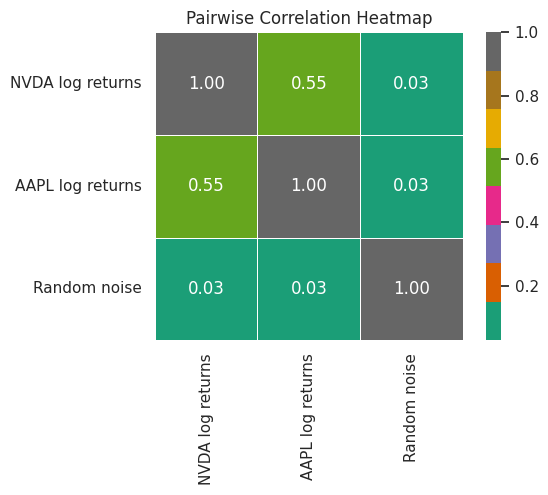

In [39]:
# Compute the correlation matrix
correlation_matrix = data_kde.corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Dark2', square=True, linewidths=.5)

plt.title('Pairwise Correlation Heatmap')
plt.show()


The above correlation reinforces the view of positive correlation between the share data.

<a id='another_cell4'></a>

<font color='turquoise'><font size='4'>**Further Analysis and Visualisations**</font>

<font size='4'>**Testing for Fat Tails**</font>

In the realm of financial data, one of the stylised facts that stands out is the phenomenon of "fat tails."

Unlike the tails of a normal distribution, fat tails indicate that extreme events—such as large jumps or drastic drops in asset prices—occur more frequently than what a normal distribution would predict.

This heavy-tailed behavior reflects the increased likelihood of rare but significant market movements, posing both opportunities and risks for traders and investors. The presence of fat tails is a critical factor in risk management, as it underscores the need for models that can better capture the true distribution of financial returns, ensuring that extreme events are adequately anticipated and mitigated.

Below we measure for fat-tails and test for normality of the log returns.




In [40]:
# Calculate excess kurtosis for each series
nvda_kurtosis = stats.kurtosis(data_kde['NVDA log returns'])
aapl_kurtosis = stats.kurtosis(data_kde['AAPL log returns'])
random_noise_kurtosis = stats.kurtosis(data_kde['Random noise'])

print("Excess Kurtosis for NVDA log returns:", nvda_kurtosis)
print("Excess Kurtosis for AAPL log returns:", aapl_kurtosis)
print("Excess Kurtosis for Random noise:", random_noise_kurtosis)

# Calculate Skewness for each series
nvda_kurtosis = stats.skew(data_kde['NVDA log returns'])
aapl_kurtosis = stats.skew(data_kde['AAPL log returns'])
random_noise_kurtosis = stats.skew(data_kde['Random noise'])

print("Skewness for NVDA log returns:", nvda_kurtosis)
print("Skewness for AAPL log returns:", aapl_kurtosis)
print("Skewness for Random noise:", random_noise_kurtosis)

Excess Kurtosis for NVDA log returns: 6.828195372152219
Excess Kurtosis for AAPL log returns: 5.373513054942849
Excess Kurtosis for Random noise: 0.037833902189561286
Skewness for NVDA log returns: 0.20889235063578204
Skewness for AAPL log returns: -0.19647995608803448
Skewness for Random noise: 0.025849243721686174


The kurtosis of each share log returns is well above that of the random noise showing the presence of fat tails. To note that in the above code, the excess Kurtosis is derived which is the deviation from the kurtosis of a normal distribution (which has a kurtosis of 3). NVDA log returns are slightly right-skewed, while AAPL log returns are slightly left-skewed. These characteristics suggest that both stocks exhibit volatility clustering and potential for large price movements.

To test for the normality of the returns, we can  also use the Jarque-Bera test. The Jarque-Bera test is a goodness-of-fit test that determines if sample data have the skewness and kurtosis matching a normal distribution.

In [41]:
# Perform the Jarque-Bera test
jb_test_nvda = jarque_bera(filtered_data['NVDA_log_return'])
jb_test_aapl = jarque_bera(filtered_data['AAPL_log_return'])

# Print the results
print("Jarque-Bera Test for NVDA Log Returns:")
print(f"JB Statistic: {jb_test_nvda[0]}")
print(f"p-value: {jb_test_nvda[1]}")


print("Jarque-Bera Test for AAPL Log Returns:")
print(f"JB Statistic: {jb_test_aapl[0]}")
print(f"p-value: {jb_test_aapl[1]}")

# Interpret the results
if jb_test_nvda[1] < 0.05:
    print("The null hypothesis of normality for NVDA log returns is rejected at the 5% significance level.")
else:
    print("The null hypothesis of normality for NVDA log returns is not rejected at the 5% significance level.")

if jb_test_aapl[1] < 0.05:
    print("The null hypothesis of normality for AAPL log returns is rejected at the 5% significance level.")
else:
    print("The null hypothesis of normality for AAPL log returns is not rejected at the 5% significance level.")


Jarque-Bera Test for NVDA Log Returns:
JB Statistic: 4796.876599931999
p-value: 0.0
Jarque-Bera Test for AAPL Log Returns:
JB Statistic: 2975.4786545324123
p-value: 0.0
The null hypothesis of normality for NVDA log returns is rejected at the 5% significance level.
The null hypothesis of normality for AAPL log returns is rejected at the 5% significance level.


The Jarque-Bera test for each of NVDA and AAPL yield _p_-values less than 5%. In each case, the null hypothesis of normality for the log returns is rejected at the 5% significance level.

The 'fat tailness' of the log returns are also illustrated in the below _Q-Q_ plots.

Campbell _et al._ (1997) observed that a time varying conditional volatility will induce fatter tails in the unconditional distribution in the time series being modelled. This phenomenon occurs because periods of high volatility and are captured by ARCH and GARCH models

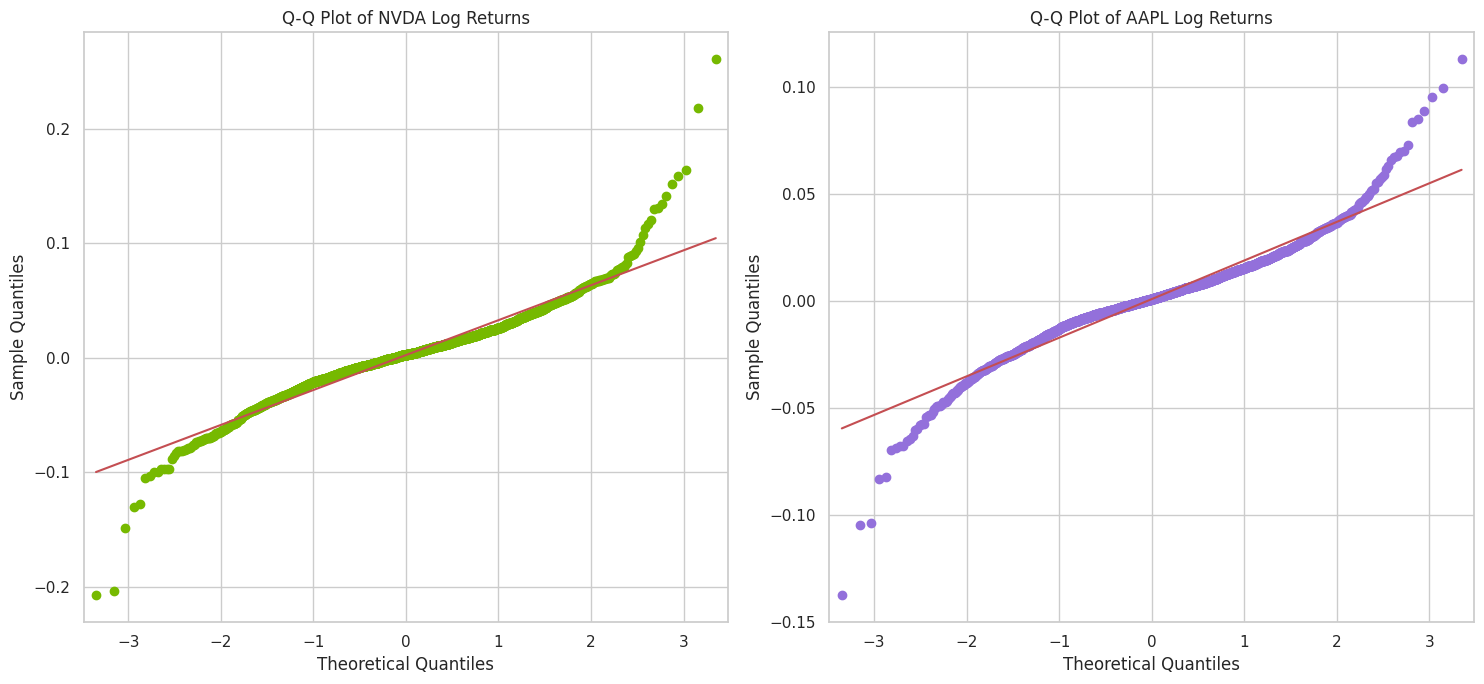

In [42]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Q-Q plot for NVDA log returns with color
res_nvda = qqplot(filtered_data['NVDA_log_return'], line='s', ax=ax[0], markerfacecolor=nvda_logo_color, markeredgecolor=nvda_logo_color)
ax[0].set_title('Q-Q Plot of NVDA Log Returns')

# Q-Q plot for AAPL log returns with color
res_aapl = qqplot(filtered_data['AAPL_log_return'], line='s', ax=ax[1], markerfacecolor=aapl_bright_color, markeredgecolor=aapl_bright_color)
ax[1].set_title('Q-Q Plot of AAPL Log Returns')

plt.tight_layout()
plt.show()



<a id='another_cell5'></a>

<font color='turquoise'><font size='4'>**Modeling and Forecasting**</font>

We will follow the below process in this workbook.

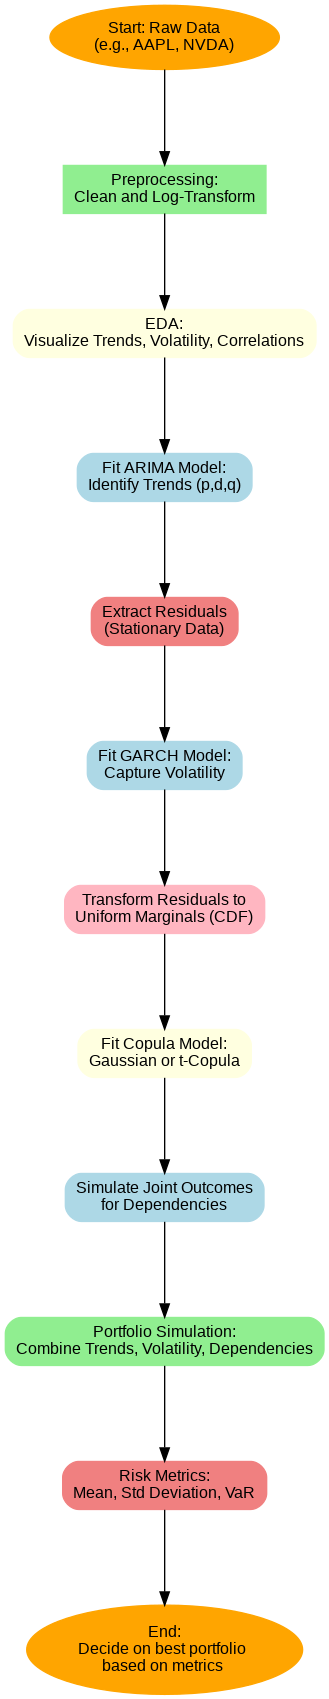

In [103]:
# Create a directed graph with additional styling
flowchart = Digraph(format="png")

# Global graph attributes for better aesthetics
flowchart.attr(rankdir="TB", splines="curved", nodesep="1", ranksep="1", fontname="Arial", fontsize="12")

# Style for all nodes
flowchart.attr("node", shape="rectangle", style="rounded,filled", color="lightblue", fontname="Arial", fontsize="12")

# Preprocessing
flowchart.node("1", "Start: Raw Data\n(e.g., AAPL, NVDA)", shape="oval", color="orange", style="filled")
flowchart.node("2", "Preprocessing:\nClean and Log-Transform", color="lightgreen", style="filled")

# Exploratory Data Analysis
flowchart.node("3", "EDA:\nVisualize Trends, Volatility, Correlations", color="lightyellow")

# ARIMA Model
flowchart.node("4", "Fit ARIMA Model:\nIdentify Trends (p,d,q)", color="lightblue")
flowchart.node("5", "Extract Residuals\n(Stationary Data)", color="lightcoral")

# GARCH Model
flowchart.node("6", "Fit GARCH Model:\nCapture Volatility", color="lightblue")

# Copula Model
flowchart.node("7", "Transform Residuals to\nUniform Marginals (CDF)", color="lightpink")
flowchart.node("8", "Fit Copula Model:\nGaussian or t-Copula", color="lightyellow")
flowchart.node("9", "Simulate Joint Outcomes\nfor Dependencies", color="lightblue")

# Portfolio Simulation
flowchart.node("10", "Portfolio Simulation:\nCombine Trends, Volatility, Dependencies", color="lightgreen")
flowchart.node("11", "Risk Metrics:\nMean, Std Deviation, VaR", color="lightcoral")

# End
flowchart.node("12", "End:\nDecide on best portfolio \nbased on metrics ", shape="oval", color="orange", style="filled")

# Connect the steps
flowchart.edges([
    ("1", "2"), ("2", "3"), ("3", "4"),
    ("4", "5"), ("5", "6"), ("6", "7"),
    ("7", "8"), ("8", "9"), ("9", "10"),
    ("10", "11"), ("11", "12")
])

# Render the flowchart to a file
flowchart.render("Enhanced_ARIMA_GARCH_Copula_Flowchart")

# Display the flowchart inline
Image("Enhanced_ARIMA_GARCH_Copula_Flowchart.png")

<font size='4'>**Determining the order of the ARIMA and GARCH models**</font>

A short overview of ARIMA and GARCH models is provided below before we start applying them to our time series.

*ARIMA Model*

 ARIMA stands for AutoRegressive Integrated Moving Average. It combines 3 components:

*  AR (AutoRegressive) Term:

  This term represents the relationship between the current value and its previous values (lags), i.e., past data points influence the current values. Mathematically, it uses coefficients to weigh the influence of previous values. An AR(1) model uses the previous day's value, AR(2) uses the previous two days, and so on.

* MA (Moving Average) Term:

  This term deals with the relationship between the current value and past errors (residuals). Mathematically, it smoothes out the data by averaging past errors. An MA(1) model considers the previous day's error, MA(2) considers the errors from the past two days, and so on.

* I (Integrated) Term:

  This term is about differencing the data to make it stationary. Stationary data is a fundamental assumption for many time series modeling techniques and is essential for accurate forecasting and modeling. Stationarity means that the statistical properties of a time series, like its mean, variance, and covariance, remain constant over time. This allows for simpler models and statistical techniques, and more accurate predictions.


*GARCH Model*

GARCH stands for Generalized AutoRegressive Conditional Heteroskedasticity. It extends the ARCH model and focuses on volatility (variance) over time.

To note that for GARCH models, conditional variance refers to the variance of the time series returns given past information. This changes over time. However, the unconditional which is the long-term average variance of the time series. It does not change over time and represents the expected variance of the series without conditioning on past information (meeting the stationarity requirement).


* AR (AutoRegressive) Term in GARCH:

  Here, it refers to the lagged values of past volatility (squared errors).

  Just like in ARIMA, it looks back at past data to predict future volatility. If today's volatility is high, it might indicate that tomorrow's volatility could also be high. Hence why we observe volatility clustering.

* MA (Moving Average) Term in GARCH:

  This term represents the lagged past squared residuals (errors).

  It uses past squared errors to predict future volatility. Large past errors contribute to higher future volatility predictions.

  For instance, if you predicted a calm market but saw a huge unexpected drop, the MA term in GARCH would use this error to adjust its future volatility predictions.

In essence, both ARIMA and GARCH models rely on past data, but while ARIMA focuses on the actual values and their errors, GARCH models concentrate on volatility and its errors. They help capture the dynamic nature of time series data, making predictions more accurate and reflective of real-world behavior.

**Combining the two gives:**

<font color='Salmon'>
\begin{equation}
y_t =\mu + \sum_{i=1}^{p} a_i y_{t-i} + \sum_{j=1}^{q} b_j \epsilon_{t-j} + \epsilon_t
\end{equation}
</font>


Here, <font color='Salmon'>\$ y_t \$</font> is the value (in our case, log return) at time <font color='Salmon'>\$ t \$</font>, <font color='Salmon'> \$ \mu \$</font> is the mean, <font color='Salmon'> \$ a_i \$ </font> are the coefficients for the autoregressive part, <font color='Salmon'> \$ b_j \$ </font> are the coefficients for the moving average part, and <font color='Salmon'> \$ \epsilon_t \$ </font> represents the error term at time <font color='Salmon'>\$ t \$</font>.

The  <font color='Salmon'> \$ \epsilon_t \$ </font>is governed by the GARCH model which also controls the volatility:

<font color='Salmon'>
\begin{equation}
\sigma_t^2 = \alpha_0 + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
\end{equation}
</font>


Where:

* <font color='Salmon'> \$ \sigma_t^2 \$ </font> represents the variance (volatility) of the time series at time <font color='Salmon'>\$ 𝑡 \$</font>. In financial terms, it measures how much the returns are expected to fluctuate at time <font color='Salmon'>\$ 𝑡 \$</font>.

* <font color='Salmon'>\$ \alpha_0 \$</font> is a constant term, representing the long-run average variance. It's the baseline level of volatility when all other terms are zero.

* <font color='Salmon'>\$ \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 \$</font> represents the impact of past squared error terms (<font color='Salmon'>\$  \epsilon_{t-i}^2 \$</font>) on current volatility. The coefficients
<font color='Salmon'>\$ \alpha_i \$ </font> determine how much weight past squared errors have. The sum means we're considering multiple past error terms up to lag <font color='Salmon'>\$ 𝑝 \$</font>.

* <font color='Salmon'>\$ \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2 \$ </font>captures the impact of past variances (<font color='Salmon'>\$ \sigma_{t-j}^2 \$ </font>) on current volatility. The coefficients <font color='Salmon'>\$ \beta_j \$ </font> indicate the weight of past variances. The sum indicates that we're taking into account multiple past variances up to lag <font color='Salmon'>\$ q \$</font>.

To note that <font color='Salmon'> \$ \epsilon_t = \sigma_𝑡 \cdot z_t\$ </font> where:

* <font color='Salmon'> \$ z_t \sim \text{i.i.d.} \ \mathcal{N}(0, 1) \$ </font> . I.e, it follows is a standard normal random variable. It represents the "shock" or unexpected change at time <font color='Salmon'> \$ t \$</font>. The current error term is influenced by both the current volatility and a random shock.

We proceed by first testing each series to see if they contain a unit root, and the need for differencing for stationarity. Then we proceed with the Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF, also called Partial ACF) plots which give an idea of the order of the time series models that are to be used.


We use the Augmented Dickey-Fuller (ADF) test to determine whether a time series is stationary or has a unit root, which indicates potential non-stationarity.

The test uses a t-statistic to test the null hypothesis that the series has a unit root (is non-stationary) against the alternative hypothesis that it does not. If the calculated test statistic is more negative than the critical value, the null hypothesis of a unit root is rejected, indicating that the series is stationary.


In [43]:
# Perform the ADF test for NVDA log returns
adf_test_nvda = adfuller(filtered_data['NVDA_log_return'])

# Perform the ADF test for AAPL log returns
adf_test_aapl = adfuller(filtered_data['AAPL_log_return'])

# Print the results
print("ADF Test for NVDA Log Returns:")
print(f"ADF Statistic: {adf_test_nvda[0]}")
print(f"p-value: {adf_test_nvda[1]}")
print(f"Number of Lags Used: {adf_test_nvda[2]}")
print(f"Number of Observations Used: {adf_test_nvda[3]}")
print("Critical Values:")
for key, value in adf_test_nvda[4].items():
    print(f"\t{key}: {value}")
print(f"Maximized Information Criterion (AIC): {adf_test_nvda[5]}\n")

print("ADF Test for AAPL Log Returns:")
print(f"ADF Statistic: {adf_test_aapl[0]}")
print(f"p-value: {adf_test_aapl[1]}")
print(f"Number of Lags Used: {adf_test_aapl[2]}")
print(f"Number of Observations Used: {adf_test_aapl[3]}")
print("Critical Values:")
for key, value in adf_test_aapl[4].items():
    print(f"\t{key}: {value}")
print(f"Maximized Information Criterion (AIC): {adf_test_aapl[5]}\n")

# Interpret the results
if adf_test_nvda[1] < 0.05:
    print("The null hypothesis of a unit root for NVDA log returns is rejected at the 5% significance level.")
else:
    print("The null hypothesis of a unit root for NVDA log returns is not rejected at the 5% significance level.")

if adf_test_aapl[1] < 0.05:
    print("The null hypothesis of a unit root for AAPL log returns is rejected at the 5% significance level.")
else:
    print("The null hypothesis of a unit root for AAPL log returns is not rejected at the 5% significance level.")


ADF Test for NVDA Log Returns:
ADF Statistic: -16.01940542752881
p-value: 6.228509623753795e-29
Number of Lags Used: 8
Number of Observations Used: 2451
Critical Values:
	1%: -3.433020812670638
	5%: -2.8627199404827794
	10%: -2.567398129768597
Maximized Information Criterion (AIC): -10074.021956359484

ADF Test for AAPL Log Returns:
ADF Statistic: -15.397763117938876
p-value: 3.245641301417452e-28
Number of Lags Used: 8
Number of Observations Used: 2451
Critical Values:
	1%: -3.433020812670638
	5%: -2.8627199404827794
	10%: -2.567398129768597
Maximized Information Criterion (AIC): -12675.090413568454

The null hypothesis of a unit root for NVDA log returns is rejected at the 5% significance level.
The null hypothesis of a unit root for AAPL log returns is rejected at the 5% significance level.


From the above results, we can conclude that both series are stationary at 5% level of significance.

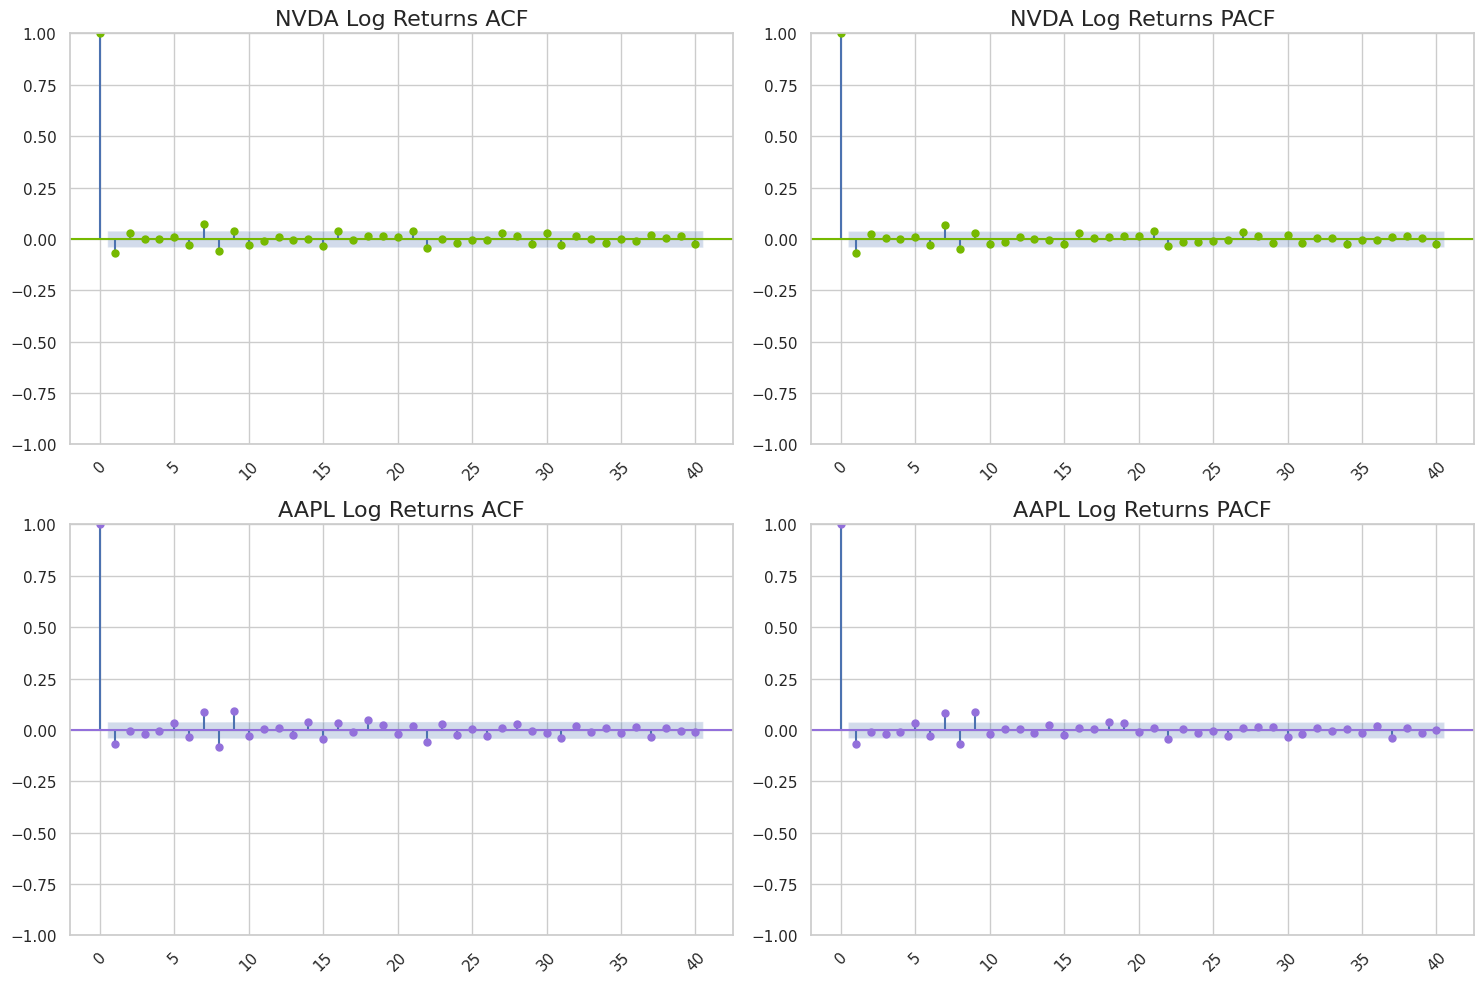

In [44]:
# ACF/PACF plots


# Set the highlight color
highlight_color = 'red'
# Create subplots for ACF and PACF
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# NVDA log returns ACF
plot_acf(filtered_data['NVDA_log_return'], ax=ax[0, 0], lags=40, color=nvda_logo_color)
ax[0, 0].set_title('NVDA Log Returns ACF', size=16)
ax[0, 0].tick_params(axis='x', rotation=45)

# NVDA log returns PACF
plot_pacf(filtered_data['NVDA_log_return'], ax=ax[0, 1], lags=40, color=nvda_logo_color)
ax[0, 1].set_title('NVDA Log Returns PACF', size=16)
ax[0, 1].tick_params(axis='x', rotation=45)

# AAPL log returns ACF
plot_acf(filtered_data['AAPL_log_return'], ax=ax[1, 0], lags=40, color=aapl_bright_color)
ax[1, 0].set_title('AAPL Log Returns ACF', size=16)
ax[1, 0].tick_params(axis='x', rotation=45)

# AAPL log returns PACF
plot_pacf(filtered_data['AAPL_log_return'], ax=ax[1, 1], lags=40, color=aapl_bright_color)
ax[1, 1].set_title('AAPL Log Returns PACF', size=16)
ax[1, 1].tick_params(axis='x', rotation=45)

# Highlight significant lags
def highlight_significant_lags(ax, threshold, color):
    for line in ax.lines[1:]:  # Skip the first line (confidence interval line)
        if np.abs(line.get_ydata().max()) > threshold:
            line.set_color(color)
            line.set_linewidth(2.5)

highlight_threshold = 1.00  # Example threshold, value set at 1 here, set value lower to use
highlight_significant_lags(ax[0, 0], highlight_threshold, highlight_color)
highlight_significant_lags(ax[0, 1], highlight_threshold, highlight_color)
highlight_significant_lags(ax[1, 0], highlight_threshold, highlight_color)
highlight_significant_lags(ax[1, 1], highlight_threshold, highlight_color)

plt.tight_layout()
plt.show()




Generally we, expect the below behaviour for an ARMA (p, q) process:


<table border="1" cellspacing="0" cellpadding="5">
  <thead>
    <tr>
      <th>Model</th>
      <th>ACF Behavior</th>
      <th>PACF Behavior</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>AR(p) (Autoregressive of order p)</td>
      <td>Decays exponentially or as a damped sine wave</td>
      <td>Cuts off after lag p</td>
    </tr>
    <tr>
      <td>MA(q) (Moving Average of order q)</td>
      <td>Cuts off after lag q</td>
      <td>Decays exponentially or as a damped sine wave</td>
    </tr>
    <tr>
      <td>ARMA(p, q) (Autoregressive Moving Average)</td>
      <td>Mix of exponential decay and cut-offs based on p and q</td>
      <td>Mix of exponential decay and cut-offs based on p and q</td>
    </tr>
  </tbody>
</table>

Unfortunately, from the above graphs it is quite difficult to determine the order of the ARMA as whilst there a few lags that seem significant, they do not particularly stand-out.

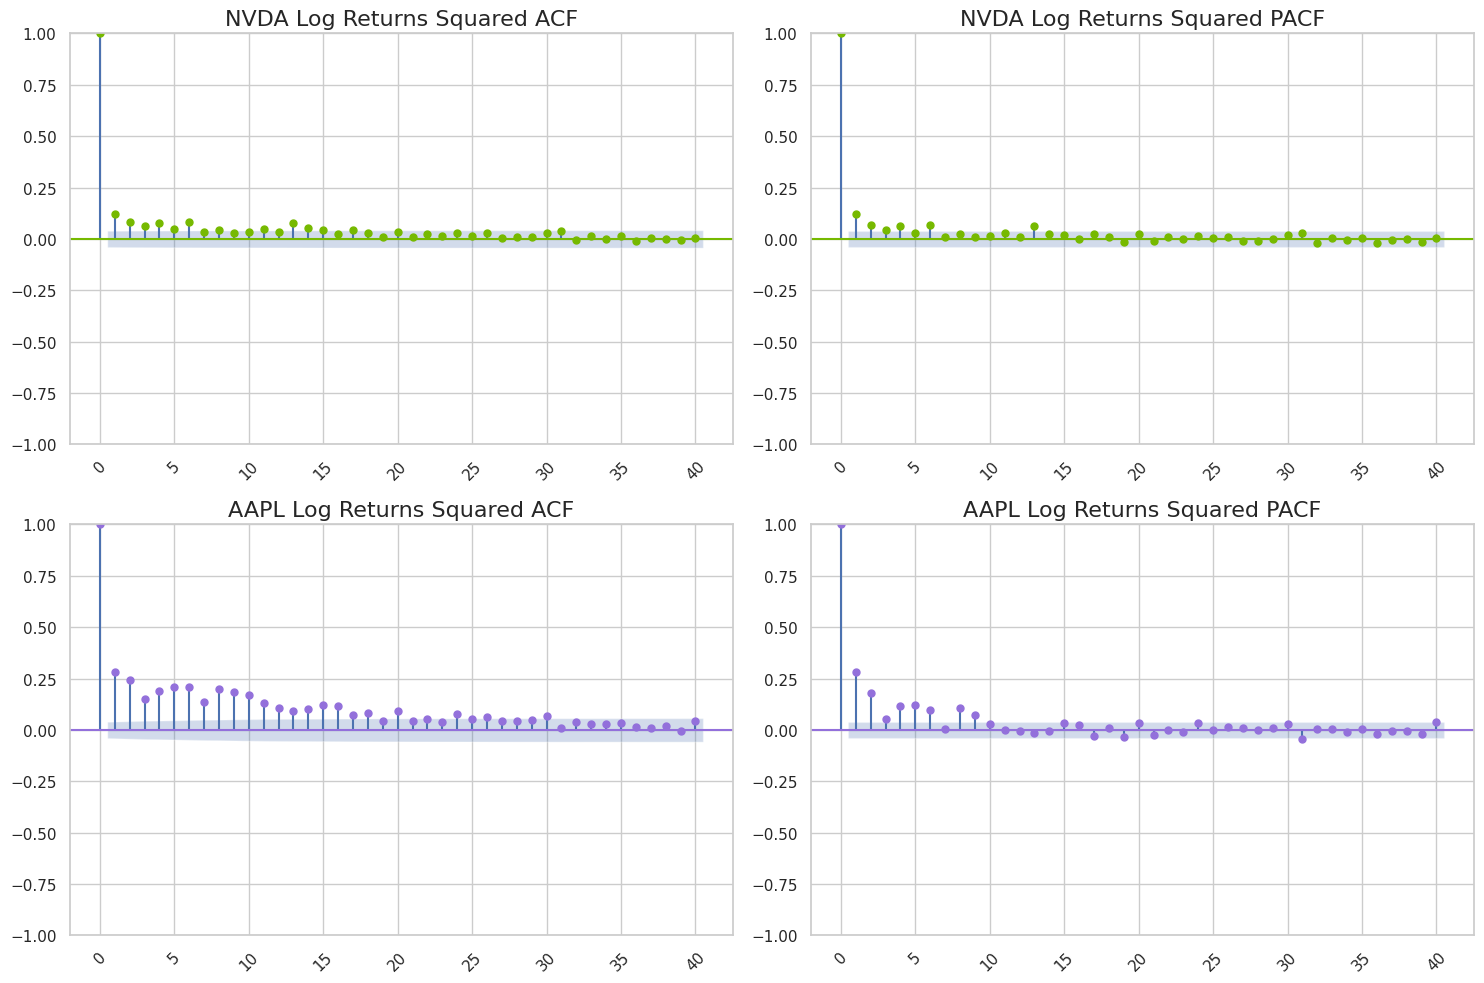

In [45]:
filtered_data['NVDA_log_return_squared'] = filtered_data['NVDA_log_return'] ** 2
filtered_data['AAPL_log_return_squared'] = filtered_data['AAPL_log_return'] ** 2

# Create subplots for ACF and PACF of squared log returns
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# NVDA log returns squared ACF
plot_acf(filtered_data['NVDA_log_return_squared'], ax=ax[0, 0], lags=40, color=nvda_logo_color)
ax[0, 0].set_title('NVDA Log Returns Squared ACF', size=16)
ax[0, 0].tick_params(axis='x', rotation=45)

# NVDA log returns squared PACF
plot_pacf(filtered_data['NVDA_log_return_squared'], ax=ax[0, 1], lags=40, color=nvda_logo_color)
ax[0, 1].set_title('NVDA Log Returns Squared PACF', size=16)
ax[0, 1].tick_params(axis='x', rotation=45)

# AAPL log returns squared ACF
plot_acf(filtered_data['AAPL_log_return_squared'], ax=ax[1, 0], lags=40, color=aapl_bright_color)
ax[1, 0].set_title('AAPL Log Returns Squared ACF', size=16)
ax[1, 0].tick_params(axis='x', rotation=45)

# AAPL log returns squared PACF
plot_pacf(filtered_data['AAPL_log_return_squared'], ax=ax[1, 1], lags=40, color=aapl_bright_color)
ax[1, 1].set_title('AAPL Log Returns Squared PACF', size=16)
ax[1, 1].tick_params(axis='x', rotation=45)

# Highlight significant lags
def highlight_significant_lags(ax, threshold, color):
    for line in ax.lines[1:]:  # Skip the first line (confidence interval line)
        if np.abs(line.get_ydata().max()) > threshold:
            line.set_color(color)
            line.set_linewidth(2.5)

highlight_threshold = 1.00  # Example threshold, value set at 1 here, set value lower to use
highlight_significant_lags(ax[0, 0], highlight_threshold, highlight_color)
highlight_significant_lags(ax[0, 1], highlight_threshold, highlight_color)
highlight_significant_lags(ax[1, 0], highlight_threshold, highlight_color)
highlight_significant_lags(ax[1, 1], highlight_threshold, highlight_color)

plt.tight_layout()
plt.show()


For a GARCH process, the below is expected.

To note, we have used squared returns (log returns) for the above ACF and PACF plots as:

* Volatility Proxy: Squared returns serve as a proxy for volatility. Volatility is essentially the variance of returns, and variance is the average of squared deviations from the mean. By squaring the returns, we get a measure that reflects the magnitude of fluctuations, regardless of direction.

* Positive Autocorrelation: Squared returns exhibit positive autocorrelation, meaning that periods of high volatility tend to be followed by high volatility, and periods of low volatility tend to be followed by low volatility. This characteristic is crucial for modeling volatility clustering, which is a common feature in financial time series.

<table border="1" cellspacing="0" cellpadding="5">
  <thead>
    <tr>
      <th>Model</th>
      <th>ACF Behavior</th>
      <th>PACF Behavior</th>
    </tr>
  </thead>
<tbody>
<tr>
<td>ARCH</td>
<td> - Significant spikes at initial lags
<br> - Indicates autocorrelation in squared returns
<br> - Reflects volatility clustering
</td>
<td> - Significant spike at lag 1
<br> - Possible significant spikes at a few more lags
<br> - Indicates that past variances can explain the current variance
</td>
</tr>
<tr>
<td>GARCH</td>
<td> - Gradual decay
<br> - Indicates persistent volatility clustering
<br> - Long-lasting effect of volatility shocks
</td>
<td> - Significant spikes at initial lags
<br> - Similar to ARCH but spikes may be less pronounced
<br> - Indicates influence of past squared returns and past variances </td>
</tr>
</tbody>
 </table>

For NVDA, it is quite difficult to say for sure which GARCH order is required, while for AAPL, a GARCH of order (2,0) seems to necessary. This is indicated by the 2 highly significant lags (at lags 1 and 2) in the PACF plot, while the ACF seems to exhibit some gradual decay, indicating the persistence of volatility shocks over time. This reflects the influence of past variances and the long-lasting effect of volatility clustering, which is characteristic of GARCH models. Beyond lag 2, the spikes would diminish, as the higher lags are explained by the first two terms - although some lags still remain significant afterwards.




To get an idea of the ARMA order, we use the _AutoARIMA_ method provided by the _pmdarima_ library that automatically finds the best-fitting ARIMA model for a given time series data. It automates the process of identifying the optimal parameters for the ARIMA model, making it easier and faster to apply without manually searching through various combinations of parameters.

Briefly, _AutoARIMA_ searches through different combinations of ARIMA parameters (p, d, q) using a stepwise approach. It evaluates the model performance based on information criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). _AutoARIMA_ fits multiple ARIMA models with different parameter combinations and selects the one with the lowest information criterion value, indicating the best fit.

AIC and BIC are measures used to compare the goodness of fit of different statistical models. They balance model complexity and fit by penalizing the number of parameters in the model.

The formula for AIC is:

<font color='Salmon'>
\begin{equation}
AIC = 2k -2ln(L)
\end{equation}
</font>

While that for BIC is:

<font color='Salmon'>
\begin{equation}
BIC = ln(n)k-2ln(L)
\end{equation}
</font>

where:

* <font color='Salmon'> \$ n \$ </font> is the number of observations.
* <font color='Salmon'> \$ k \$ </font> is the number of parameters in the model.
* <font color='Salmon'> \$ L \$ </font> is the maximum likelihood of the model.

Both AIC and BIC are used to compare different models and select the best one for a given dataset. They help prevent overfitting by penalising models with too many parameters. While AIC is more lenient, favoring models with more parameters, BIC is stricter and tends to select simpler models. AIC is more suitable when the primary concern is the goodness of fit. BIC is preferred when the goal is to avoid overfitting and prioritise model simplicity.



In [46]:
# Rename data for ease of reference
y_nvda = filtered_data['NVDA_log_return']
y_aapl = filtered_data['AAPL_log_return']

# Split Data into Training and Testing Sets
y_train_nvda, y_test_nvda = temporal_train_test_split(y_nvda, test_size=0.2)
y_train_aapl, y_test_aapl = temporal_train_test_split(y_aapl, test_size=0.2)

# Fit ARIMA model for NVDA log returns using AutoARIMA
arima_nvda = AutoARIMA(sp=1, suppress_warnings=True)
arima_nvda.fit(y_train_nvda)

# Fit ARIMA model for AAPL log returns using AutoARIMA
arima_aapl = AutoARIMA(sp=1, suppress_warnings=True)
arima_aapl.fit(y_train_aapl)

# Retrieve the best order parameters for NVDA and AAPL
nvda_order = arima_nvda.get_fitted_params()['order']
aapl_order = arima_aapl.get_fitted_params()['order']

# Print the order parameters for AutoARIMA
print("Best ARIMA Order for NVDA:", nvda_order)
print("Best ARIMA Order for AAPL:", aapl_order)

def print_arima_results(result, stock_name):
    print(f"ARIMA Model Results for {stock_name} Log Returns:")
    print(result.summary())

    # Extract p-values
    p_values = result.pvalues
    print("\nP-values:")
    for param, p_value in p_values.items():
        significance = "Significant" if p_value < 0.05 else "Not Significant"
        print(f"{param}: {p_value} ({significance})")
    print("\n")

# Fit ARIMA model for NVDA log returns using statsmodels with best order parameters
arima_nvda_stats = ARIMA(y_train_nvda, order=nvda_order)
arima_result_nvda_stats = arima_nvda_stats.fit()

# Fit ARIMA model for AAPL log returns using statsmodels with best order parameters
arima_aapl_stats = ARIMA(y_train_aapl, order=aapl_order)
arima_result_aapl_stats = arima_aapl_stats.fit()

# Print the results for NVDA
print_arima_results(arima_result_nvda_stats, "NVDA")

# Print the results for AAPL
print_arima_results(arima_result_aapl_stats, "AAPL")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best ARIMA Order for NVDA: (2, 0, 0)
Best ARIMA Order for AAPL: (0, 0, 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

ARIMA Model Results for NVDA Log Returns:
                               SARIMAX Results                                
Dep. Variable:        NVDA_log_return   No. Observations:                 1968
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4120.680
Date:                Sun, 30 Mar 2025   AIC                          -8233.360
Time:                        06:43:59   BIC                          -8211.021
Sample:                             0   HQIC                         -8225.151
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.510      0.012       0.000       0.003
ar.L1         -0.0772      0.015     -5.039      0.000      -0.107      -0.047
ar.L2     

NVDA Log Returns: The ARIMA(2, 0, 0) model includes two autoregressive terms (_ar.L1_ and _ar.L2_). The first term (_ar.L1_) is highly significant, while the second term (_ar.L2_) is not. The constant term is significant, suggesting a small but significant mean. The model's diagnostics indicate non-normality (given by the Jarque Bera test results) and potential heteroskedasticity (the statistic value of the Heteroskedascity test is significant) in the residuals.

AAPL Log Returns: The ARIMA(0, 0, 1) model includes one moving average term (_ma.L1_) that is highly significant. The constant term is also significant. The diagnostics indicate non-normality and potential heteroskedasticity in the residuals.

These variance of the residuals from the respective ARIMA models is given by sigma2 here. Both values are relatively small, suggesting that the models fit the data reasonably well, but further assessment might be needed to ensure the residuals meet other assumptions, such as normality and homoscedasticity.

The issue unforturnately is that the ARIMA model selected by _AutoARIMA_ might have included a term (_ar.L2_) that is statistically insignificant which could be due to overfitting or simply due to the nature of the data.

With regards to the non-normality and heteroskedasticity of the residuals, these should be further addressed by the GARCH models.

Given that the second AR term is not significant for NVDA, we consider simplifying the model by removing the insignificant term and see whether it improves model performance or keeps it similar while simplifying the model structure.

In [47]:
# Refit ARIMA model for NVDA log returns, this time with order (1,0,0)
arima_nvda_stats_1 = ARIMA(y_train_nvda, order=(1,0,0))
arima_result_nvda_stats_1 = arima_nvda_stats_1.fit()

# Print the results for NVDA
print_arima_results(arima_result_nvda_stats_1, "NVDA")


ARIMA Model Results for NVDA Log Returns:
                               SARIMAX Results                                
Dep. Variable:        NVDA_log_return   No. Observations:                 1968
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4119.570
Date:                Sun, 30 Mar 2025   AIC                          -8233.139
Time:                        06:44:26   BIC                          -8216.385
Sample:                             0   HQIC                         -8226.982
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.656      0.008       0.000       0.003
ar.L1         -0.0795      0.015     -5.433      0.000      -0.108      -0.051
sigma2    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Removing the insignificant term decreases the maximum log-likelihood. The AIC registers very little change while the BIC becomes more negative (better) - this is because the BIC tends to favour more parsimonious models (i.e. ones with less parameters) to a greater extent than the AIC.

We can now proceed with fitting the GARCH models. For NVDA, we fit a GARCH(1, 1) model while for AAPL we fit a GARCH(2, 0) model as indicated by its ACF and PACF plots.

In [48]:
# Obtain ARIMA Residuals
residuals_nvda_arima_1 = arima_result_nvda_stats_1.resid
residuals_aapl_arima = arima_result_aapl_stats.resid

# Fit GARCH model for NVDA log returns
garch_nvda_11 = arch_model(residuals_nvda_arima_1, vol='Garch', p=1, q=1, rescale=False, mean='zero')  # Set rescale=False
garch_result_nvda_11 = garch_nvda_11.fit(disp='off')

# Fit GARCH model for AAPL log returns
garch_aapl_20 = arch_model(residuals_aapl_arima, vol='Garch', p=2, q=0, rescale=False, mean='zero')  # Set rescale=False
garch_result_aapl_20 = garch_aapl_20.fit(disp='off')

# Print Summary Results
# Print summary of GARCH results for NVDA log returns
print("GARCH Model Results for NVDA Log Returns:")
print(garch_result_nvda_11.summary())

# Print summary of GARCH results for AAPL Log Returns:")
print("GARCH Model Results for AAPL Log Returns:")
print(garch_result_aapl_20.summary())

GARCH Model Results for NVDA Log Returns:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                4241.21
Distribution:                  Normal   AIC:                          -8476.42
Method:            Maximum Likelihood   BIC:                          -8459.66
                                        No. Observations:                 1968
Date:                Sun, Mar 30 2025   Df Residuals:                     1968
Time:                        06:44:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.898

Here, _omega_ parameter represents the baseline level of volatility. Significant values indicate that the models effectively incorporate the constant variance component.

The _alpha_ parameters measure the impact of past squared residuals on current volatility. Significant _alpha_ values indicate that past shocks influence current volatility.

NVDA: _alpha[1]_ is significant.

AAPL: Both _alpha[1]_ and _alpha[2]_ are highly significant.

The _beta_ parameters measure the impact of past variances on current volatility. High and significant _beta_ values for NVDA indicate that past variances strongly influence current volatility.

Both models have very low (negative) AIC and BIC values, indicating a good fit. We further test if we have captured all the salient features present in our data.

To note, GARCH models are non-linear models used for predicting volatility, not the actual values of the time series. Thus, R²—which measures the proportion of variance explained in the dependent variable—is not always meaningful for volatility modeling. Hence it is not used here.

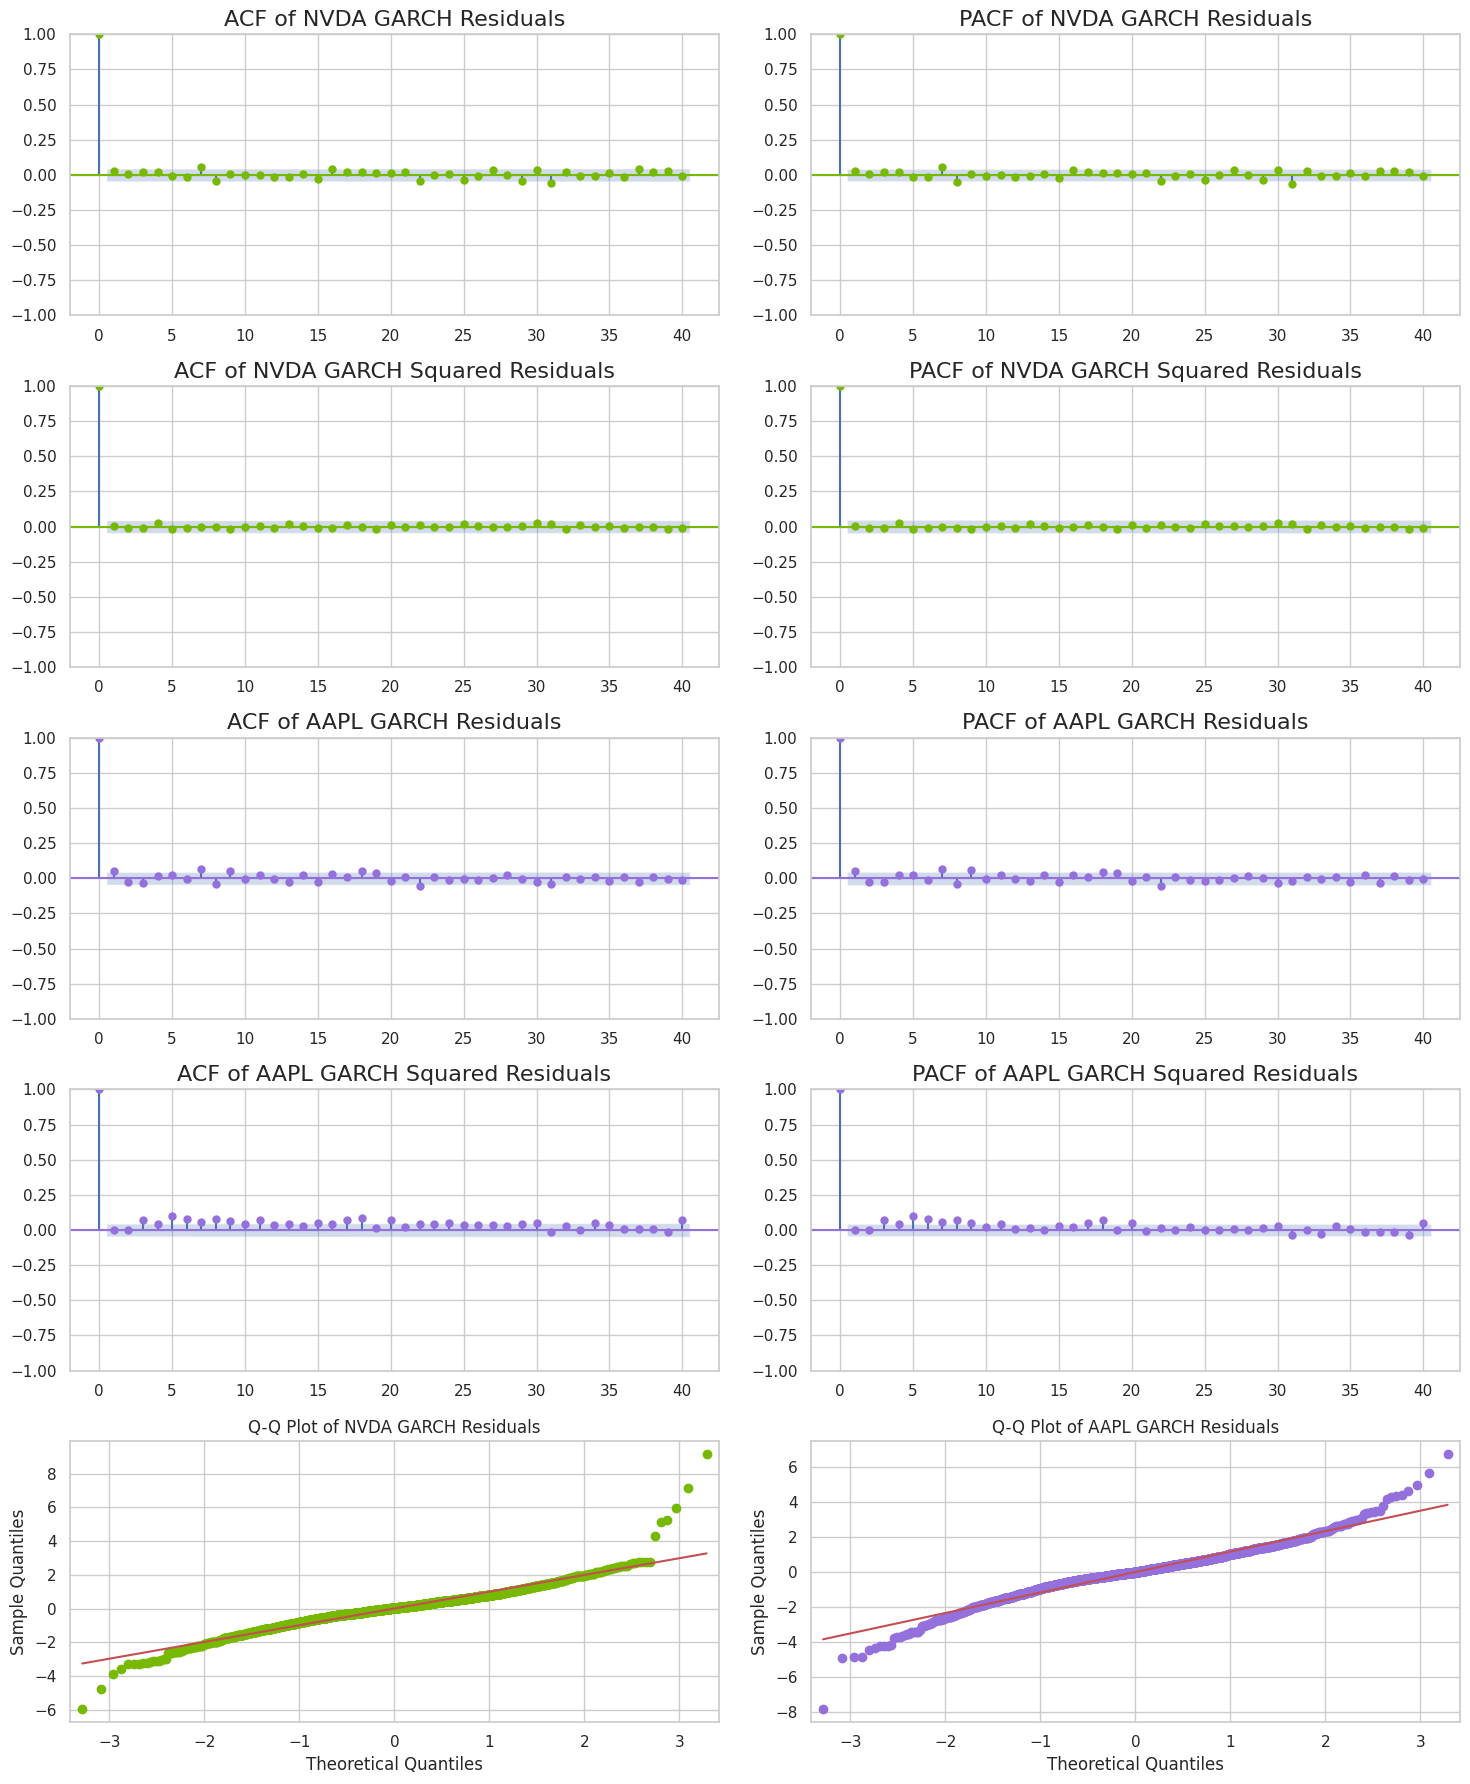

In [49]:
# Get the standardised residuals from the GARCH model
# Standardized residuals account for heteroscedasticity by normalizing the raw residuals, which is especially important in GARCH models where volatility varies over time
# They are more suitbale for diagnostic tests and model comparison


residuals_nvda_11 = garch_result_nvda_11.std_resid
residuals_aapl_20 = garch_result_aapl_20.std_resid

# Calculate the squared residuals
residuals_nvda_squared_11 = residuals_nvda_11 ** 2
residuals_aapl_squared_20 = residuals_aapl_20 ** 2

# Plot ACF and PACF for the residuals and squared residuals
fig, ax = plt.subplots(5, 2, figsize=(15, 18))

# NVDA residuals ACF
plot_acf(residuals_nvda_11, ax=ax[0, 0], lags=40, color= nvda_logo_color)
ax[0, 0].set_title('ACF of NVDA GARCH Residuals', size=16)

# NVDA residuals PACF
plot_pacf(residuals_nvda_11, ax=ax[0, 1], lags=40, color= nvda_logo_color)
ax[0, 1].set_title('PACF of NVDA GARCH Residuals', size=16)

# NVDA squared residuals ACF
plot_acf(residuals_nvda_squared_11, ax=ax[1, 0], lags=40, color=nvda_logo_color)
ax[1, 0].set_title('ACF of NVDA GARCH Squared Residuals', size=16)

# NVDA squared residuals PACF
plot_pacf(residuals_nvda_squared_11, ax=ax[1, 1], lags=40, color=nvda_logo_color)
ax[1, 1].set_title('PACF of NVDA GARCH Squared Residuals', size=16)

# AAPL residuals ACF
plot_acf(residuals_aapl_20, ax=ax[2, 0], lags=40, color=aapl_bright_color)
ax[2, 0].set_title('ACF of AAPL GARCH Residuals', size=16)

# AAPL residuals PACF
plot_pacf(residuals_aapl_20, ax=ax[2, 1], lags=40, color=aapl_bright_color)
ax[2, 1].set_title('PACF of AAPL GARCH Residuals', size=16)

# AAPL squared residuals ACF
plot_acf(residuals_aapl_squared_20, ax=ax[3, 0], lags=40, color=aapl_bright_color)
ax[3, 0].set_title('ACF of AAPL GARCH Squared Residuals', size=16)

# AAPL squared residuals PACF
plot_pacf(residuals_aapl_squared_20, ax=ax[3, 1], lags=40, color=aapl_bright_color)
ax[3, 1].set_title('PACF of AAPL GARCH Squared Residuals', size=16)

# Q-Q plot for NVDA residuals
qqplot(residuals_nvda_11, line='s', ax=ax[4, 0], markerfacecolor=nvda_logo_color, markeredgecolor=nvda_logo_color)
ax[4, 0].set_title('Q-Q Plot of NVDA GARCH Residuals')

# Q-Q plot for AAPL residuals
qqplot(residuals_aapl_20, line='s', ax=ax[4, 1], markerfacecolor=aapl_bright_color, markeredgecolor=aapl_bright_color)
ax[4, 1].set_title('Q-Q Plot of AAPL GARCH Residuals')

plt.tight_layout()
plt.show()


The ACF and PACF of the residuals and squared residuals for NDVA seem to inidcate that most of the salient features have been taken care. However for AAPL the squared residuals still exhibit some signifcant lags - although much less than before.

The Q-Q plots do seem to exhibit some improvement, with the deviations at the 'tails' being less; the points lie closer to the line in each case - we further ascertain this by cheking the kurtosis of the residuals.

We need to test higher order GARCH models to see if there is any improvement.










In [50]:
# Calculate excess kurtosis for each series
nvda_kurtosis_resiudals = stats.kurtosis(residuals_nvda_11)
aapl_kurtosis_residuals = stats.kurtosis(residuals_aapl_20)
print("Excess Kurtosis for NVDA GARCH residuals:", nvda_kurtosis)
print("Excess Kurtosis for AAPL GARCH residuals:", aapl_kurtosis)

Excess Kurtosis for NVDA GARCH residuals: 0.20889235063578204
Excess Kurtosis for AAPL GARCH residuals: -0.19647995608803448


The excess kurtosis has decreased significantly and is now much closer to that of a normal distribution, which shows that the GARCH model has more or less successfully captured the heavy tails inherent in the data.

In [51]:
# Fit GARCH(2,1) model for AAPL log returns
garch_aapl_21 = arch_model(residuals_aapl_arima, vol='Garch', p=2, q=1, rescale=False, mean='zero')
garch_result_aapl_21 = garch_aapl_21.fit(disp='off')

# Fit GARCH(3,0) model for AAPL log returns
garch_aapl_30 = arch_model(residuals_aapl_arima, vol='Garch', p=3, q=0, rescale=False, mean='zero')
garch_result_aapl_30 = garch_aapl_30.fit(disp='off')

# Fit GARCH(1,1) model for AAPL log returns
garch_aapl_11 = arch_model(residuals_aapl_arima, vol='Garch', p=1, q=1, rescale=False, mean='zero')
garch_result_aapl_11 = garch_aapl_11.fit(disp='off')

# Fit GARCH(2,2) model for AAPL log returns
garch_aapl_22 = arch_model(residuals_aapl_arima, vol='Garch', p=2, q=2, rescale=False, mean='zero')
garch_result_aapl_22 = garch_aapl_22.fit(disp='off')

# Print summaries of all fitted models
print("GARCH(2,0) Model Summary:") #add first GARCH (2,0) for comparison
print(garch_result_aapl_20.summary())

print("\nGARCH(2,1) Model Summary:")
print(garch_result_aapl_21.summary())

print("\nGARCH(3,0) Model Summary:")
print(garch_result_aapl_30.summary())

print("\nGARCH(1,1) Model Summary:")
print(garch_result_aapl_11.summary())

print("\nGARCH(2,2) Model Summary:")
print(garch_result_aapl_22.summary())


GARCH(2,0) Model Summary:
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:                5103.84
Distribution:                  Normal   AIC:                          -10201.7
Method:            Maximum Likelihood   BIC:                          -10184.9
                                        No. Observations:                 1968
Date:                Sun, Mar 30 2025   Df Residuals:                     1968
Time:                        06:44:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.7276e-04  1.121e-05

*Interpreting the results and comparing the model performance:*
1. Model Performance and Fit
 Log-Likelihood:
 * GARCH(2,0): 5103.84
 * GARCH(2,1): 5251.98
 * GARCH(3,0): 5187.72
 * GARCH(1,1): 5244.54
 * GARCH(2,2): 5250.97

The GARCH(2,1) model achieves the highest log-likelihood, indicating it provides the best fit to the data. The GARCH(2,2) follows closely but is excluded due to (highly) insignificant beta terms. Both GARCH(3,0) and GARCH(2,0) lag behind in performance. For the GARCH(2,1), the _alpha[2]_ term exhibits less significance (not significant at 5% level of significance but significant at 10%). We still persist with it to gauge whether is shows improvement over the initial GARCH(2,0) model fitted.

2. AIC (Akaike Information Criterion):
   
   * GARCH(2,0): -10201.7
   * GARCH(2,1): -10496.0
   * GARCH(3,0): -10345.1
   * GARCH(1,1): -10466.3

GARCH(2,1) exhibits the lowest AIC, indicating the best balance between fit and complexity. GARCH(1,1) closely competes, while GARCH(2,0) ranks the least favorable.

3. BIC (Bayesian Information Criterion):
  * GARCH(2,0): -10184.9
  * GARCH(2,1): -10473.6
  * GARCH(3,0): -10302.4
  * GARCH(1,1): -10483.4

Here the GARCH(1,1) achieves the lowest BIC values, reaffirming its status as the most parsimonious model. GARCH(2,1) performs well but with slightly higher complexity than GARCH(1,1), noting that the BIC penalizes the use of additional paramaters more severely than the AIC.

2. Parameter Estimates

* GARCH(2,0):
 * _omega_ = 1.7276e-04: Larger baseline variance compared to other models, reflecting higher reliance on initial variance levels.

 * _alpha[1]_ = 0.1000, _alpha[2]_ = 0.1000: Significant short-term effects from two ARCH terms. No beta term means this model cannot capture long-term persistence in volatility (i.e. the tendency for volatility to continue over time).

* GARCH(2,1):

 * _omega_ = 3.1097e-05: Smaller baseline variance, appropriate for capturing dynamic variance changes.
 * _alpha[1]_ = 0.0900, _alpha[2]_ = 0.0900: Both ARCH terms are significant (at 10% level of significane), capturing short-term reactions to recent shocks.
 * _beta[1]_ = 0.7300: Moderate persistence indicating dynamic long-term volatility effects.

* GARCH(3,0):
 * _omega_ = 2.5177e-04: Higher baseline variance with reliance on static components.
 * _alpha[1]_ = 0.0693, _alpha[2]_ = 0.0891, _alpha[3]_ = 0.0695: Significant ARCH terms effectively modeling short-term volatility changes, but lacks beta terms for persistence.

* GARCH(1,1):
 * _omega_ = 6.9105e-06: The smallest baseline variance, showing reliance on its dynamic components.
 * _alpha[1]_ = 0.1214: Captures significant short-term volatility.
 * _beta[1]_ = 0.8325: The highest persistence in volatility, meaning shocks have long-lasting effects.

All models have significant _alpha_ coefficients (at 10% level of significance), capturing short-term shocks in volatility. Models with beta terms such as GARCH(2,1) and GARCH(1,1) outperform ARCH-like models (GARCH(2,0) and GARCH(3,0)) in capturing volatility persistence.

GARCH(2,2) is excluded from further analysis due to insignificant beta terms.

Overall, the GARCH(2,1) model provides the best fit overall, capturing both short-term and long-term volatility dynamics effectively; balancing complexity and performance.

The GARCH(1,1) model is a strong alternative, being more parsimonious and nearly as effective.

ARCH models (e.g., GARCH(2,0) and GARCH(3,0)) underperform due to their inability to model volatility persistence.

We check the ACF and PACF plots after fitting each GARCH model and compare with those from the GARCH(2,0) model.

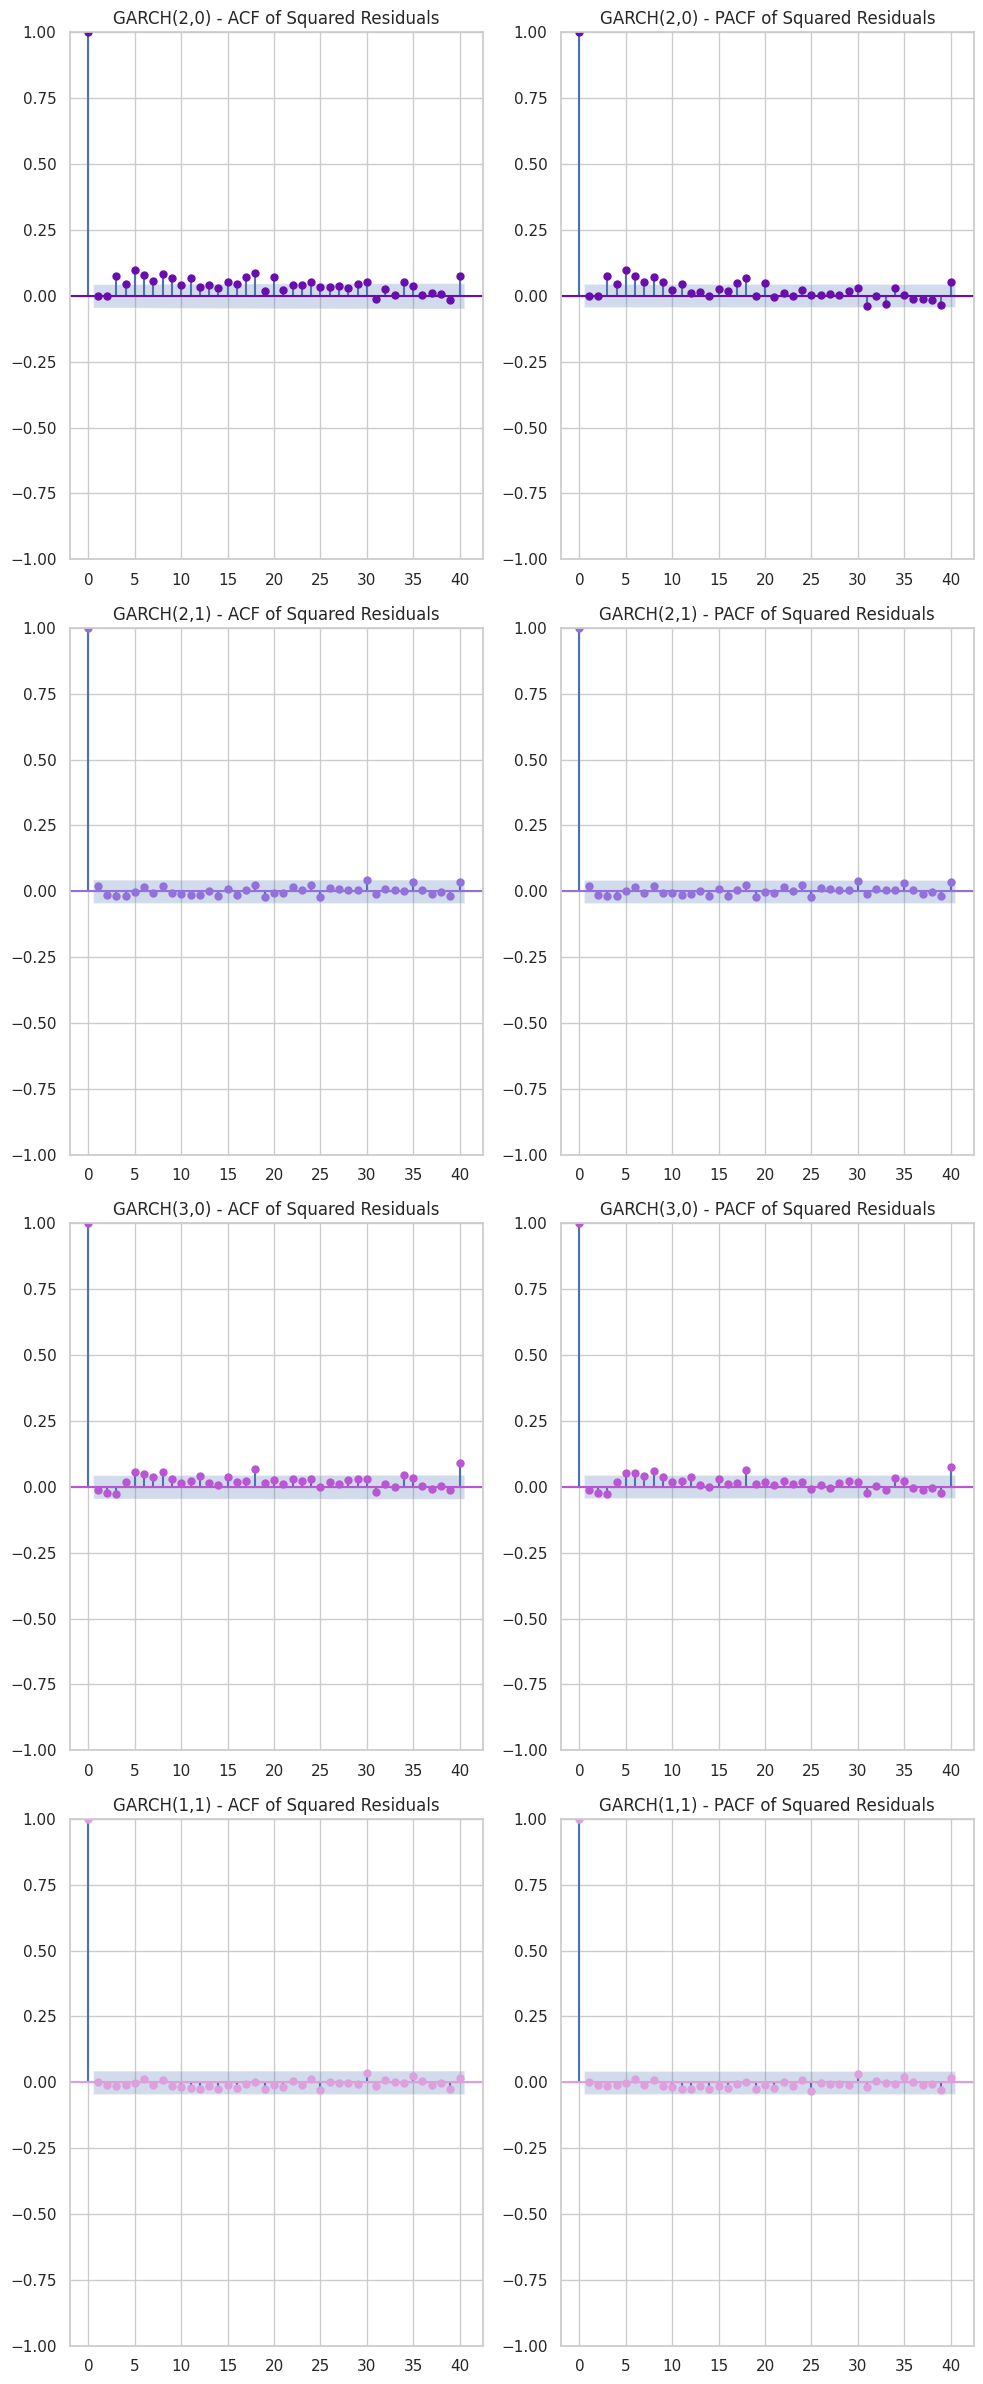

In [52]:
# Define GARCH results and labels
garch_results = [
    ("GARCH(2,0)", garch_result_aapl_20.std_resid),
    ("GARCH(2,1)", garch_result_aapl_21.std_resid),
    ("GARCH(3,0)", garch_result_aapl_30.std_resid),
    ("GARCH(1,1)", garch_result_aapl_11.std_resid),
]

# Define shades of purple for the plots
purple_shades = ['#6a0dad', '#9370db', '#ba55d3', '#dda0dd']

# Create subplots with smaller size
fig, axes = plt.subplots(len(garch_results), 2, figsize=(10, 6 * len(garch_results)))

for i, (label, residuals) in enumerate(garch_results):
    squared_residuals = residuals**2

    # Use different shades of purple for each row
    plot_acf(squared_residuals, ax=axes[i, 0], lags=40, color=purple_shades[i])
    axes[i, 0].set_title(f"{label} - ACF of Squared Residuals")

    plot_pacf(squared_residuals, ax=axes[i, 1], lags=40, color=purple_shades[i])
    axes[i, 1].set_title(f"{label} - PACF of Squared Residuals")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


From the above plost, the GARCH (1,1) and the GARCH (2,1) perform the best.

Based on this and the above model results, it seems sensible to use the GARCH (2,1) to model the volatility of AAPL.

We can hence conclude that an AR(1)-GARCH(1,1) model is suitable for NVDA while an MA(1)-GARCH(2,1) model is suitable for AAPL.

**Further ARIMA-GARCH model diagnostics**

We first proceed by testing simulated log returns from each fitted ARIMA-GARCH model versus actual test data. We inspect the fit using both the Mean Squared Error (MSE) and the Mean Absolute Error (MAE), as well as gauge it visually.

In [53]:
np.random.seed(42)  # Ensure reproducibility
# Make predictions for the test set
arima_forecast_nvda = arima_result_nvda_stats_1.get_forecast(steps=len(y_test_nvda)).predicted_mean  # ARIMA forecasts for test set

# Get GARCH forecasted conditional volatility
garch_conditional_volatility_nvda = garch_result_nvda_11.forecast(horizon=len(y_test_nvda)).variance.iloc[-len(y_test_nvda):].values

# Generate residuals from GARCH
predicted_et_nvda = np.random.normal(0, np.sqrt(garch_conditional_volatility_nvda)).flatten()

# Combine ARIMA and GARCH forecasts
combined_forecast_nvda = arima_forecast_nvda + predicted_et_nvda

# Evaluate performance using MSE and MAE
mse_nvda = mean_squared_error(y_test_nvda, combined_forecast_nvda)
mae_nvda = mean_absolute_error(y_test_nvda, combined_forecast_nvda)

print("Mean Squared Error (MSE):", mse_nvda)
print("Mean Absolute Error (MAE):", mae_nvda)



Mean Squared Error (MSE): 0.001956954615668852
Mean Absolute Error (MAE): 0.03463374904397626


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


For NVDA:

*  Mean Squared Error (MSE):

  The MSE value of 0.00196 suggests that the squared differences between actual and predicted values are relatively small. This reflects good forecasting performance, especially for financial time series data where achieving low error is challenging.

* Mean Absolute Error (MAE):

  The MAE value of 0.0346 shows that, on average, the absolute difference between actual and predicted values is modest. This further supports the effectiveness of the combined ARIMA-GARCH model.

We also check how the modeled log returns plot against actual data.

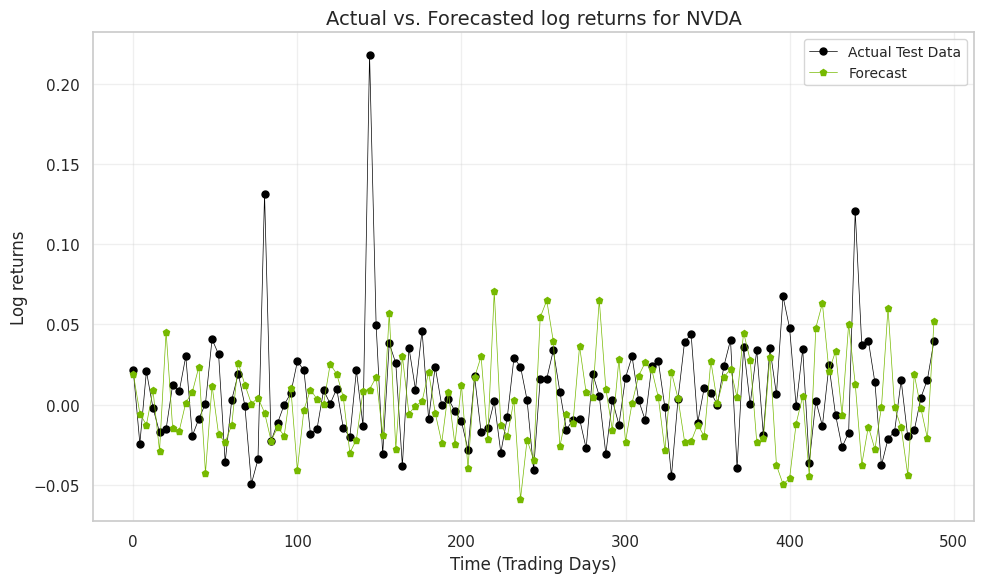

In [54]:
# Reset indices for alignment
y_test_nvda_reset = y_test_nvda.reset_index(drop=True)
combined_forecast_nvda_reset = combined_forecast_nvda.reset_index(drop=True)

# Reduce the number of data points for readability
step = max(1, len(y_test_nvda_reset) // 100)  # Sample 100
y_test_nvda_sampled = y_test_nvda_reset[::step]
combined_forecast_nvda_sampled = combined_forecast_nvda_reset[::step]

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(y_test_nvda_sampled, label="Actual Test Data", color="black", marker='o', markersize=5, linewidth=0.5)
plt.plot(combined_forecast_nvda_sampled, label="Forecast", color=nvda_logo_color, marker='p', markersize=5, linewidth=0.5)
plt.legend(loc="upper right", fontsize=10)
plt.title("Actual vs. Forecasted log returns for NVDA", fontsize=14)
plt.xlabel("Time (Trading Days)", fontsize=12)
plt.ylabel("Log returns", fontsize=12)
plt.grid(alpha=0.3)  # Add grid lines for reference
plt.tight_layout()  # Optimise layout for readability
plt.show()

The simulated NVDA log returns follow a similar pattern to that of the actual data. There are a few extreme observations present in the actual data which this sets of simulated log returns does not exhibit however.

In [55]:
np.random.seed(40)  # Ensure reproducibility, use a different seed to previous used, else can cause high correlation
# Make predictions for the test set
arima_forecast_aapl = arima_result_aapl_stats.get_forecast(steps=len(y_test_aapl)).predicted_mean  # ARIMA forecasts for test set

# Get GARCH forecasted conditional volatility
garch_conditional_volatility_aapl = garch_result_aapl_21.forecast(horizon=len(y_test_aapl)).variance.iloc[-len(y_test_aapl):].values

# Generate residuals from GARCH
predicted_et_aapl = np.random.normal(0, np.sqrt(garch_conditional_volatility_aapl)).flatten()

# Combine ARIMA and GARCH forecasts
combined_forecast_aapl = arima_forecast_aapl + predicted_et_aapl

# Evaluate performance using MSE and MAE
mse_aapl = mean_squared_error(y_test_aapl, combined_forecast_aapl)
mae_aapl = mean_absolute_error(y_test_aapl, combined_forecast_aapl)

print("Mean Squared Error (MSE):", mse_aapl)
print("Mean Absolute Error (MAE):", mae_aapl)

Mean Squared Error (MSE): 0.0005284737956413599
Mean Absolute Error (MAE): 0.01806065752086505


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


For AAPL:

* Mean Squared Error (MSE):

  The MSE value is 0.000528, which indicates very small average squared errors between actual and predicted values. This suggests that the combined ARIMA-GARCH model has achieved a high level of accuracy in forecasting for this dataset.

* Mean Absolute Error (MAE):

  The MAE value is 0.0181, which highlights that the average absolute differences between the forecasts and actual values are minimal. This further confirms that the model is capable of producing precise predictions.

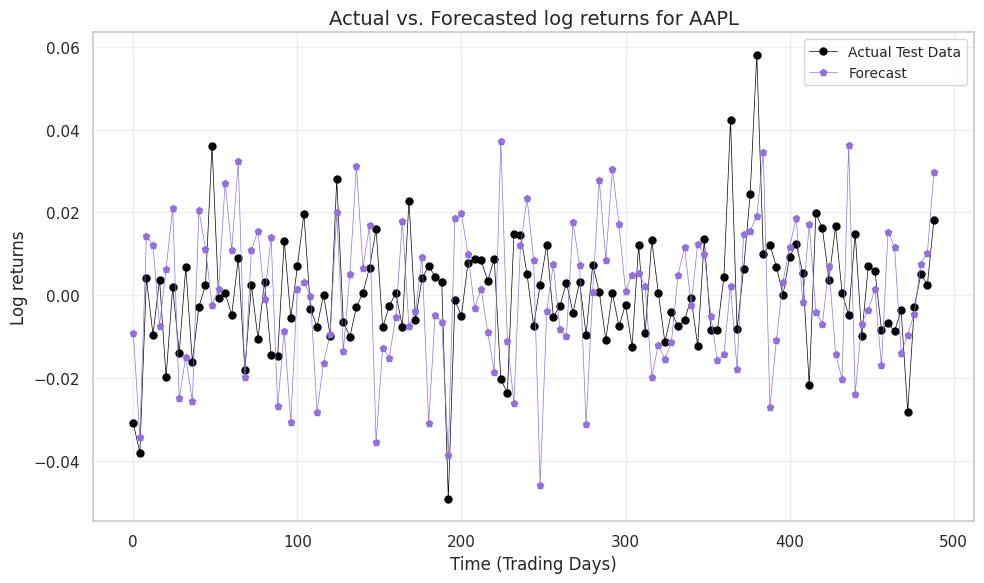

In [56]:
# Reset indices for alignment
y_test_aapl_reset = y_test_aapl.reset_index(drop=True)
combined_forecast_aapl_reset = combined_forecast_aapl.reset_index(drop=True)

# Reduce the number of data points for readability
step = max(1, len(y_test_aapl_reset) // 100)  # Sample 100
y_test_aapl_sampled = y_test_aapl_reset[::step]
combined_forecast_aapl_sampled = combined_forecast_aapl_reset[::step]

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(y_test_aapl_sampled, label="Actual Test Data", color="black", marker='o', markersize=5, linewidth=0.5)
plt.plot(combined_forecast_aapl_sampled, label="Forecast", color=aapl_bright_color, marker='p', markersize=5, linewidth=0.5)
plt.legend(loc="upper right", fontsize=10)
plt.title("Actual vs. Forecasted log returns for AAPL", fontsize=14)
plt.xlabel("Time (Trading Days)", fontsize=12)
plt.ylabel("Log returns", fontsize=12)
plt.grid(alpha=0.3)  # Add grid lines for reference
plt.tight_layout()   # Optimise layout for readability
plt.show()

The simulated AAPL log returns follow a similar pattern to that of the actual data. Contrary to for NVDA, in this case the log returns exhibit the same level of 'extreme' spikes/lows as the actual data.

So far, we have simulated each set of log returns separately. However, as previously established, there is a degree of correlation between NVDA and AAPL returns' evolution.

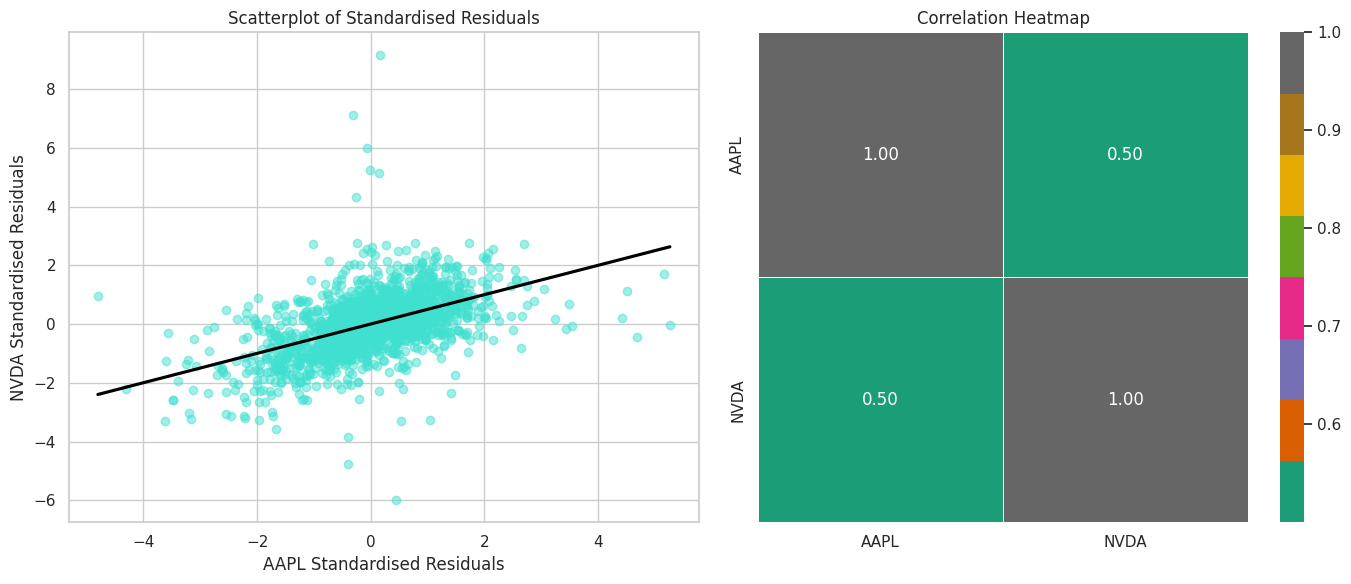

In [57]:
# Combine the residuals into a DataFrame for correlation calculation
data_residuals = pd.DataFrame({
    'AAPL': garch_result_aapl_21.std_resid,
    'NVDA': garch_result_nvda_11.std_resid
})

# Calculate the correlation matrix
corr_matrix = data_residuals.corr()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot with trendline
sns.regplot(x='AAPL', y='NVDA', data=data_residuals, ci=None,
            scatter_kws={'color': 'turquoise', 'alpha': 0.5},
            line_kws={'color': 'black'}, ax=axs[0])
axs[0].set_title('Scatterplot of Standardised Residuals')
axs[0].set_xlabel('AAPL Standardised Residuals')
axs[0].set_ylabel('NVDA Standardised Residuals')

# Heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Dark2', square=True, linewidths=.5)
axs[1].set_title('Correlation Heatmap')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [58]:
correlation_1 = combined_forecast_aapl.corr(combined_forecast_nvda)

print(f"The correlation between AAPL and NVDA forecasts is:  {correlation_1}")


The correlation between AAPL and NVDA forecasts is:  -0.019998001045186377


The correlation between the residuals from the ARIMA-GARCH models for NVDA and AAPL is 0.50. However if we were to simulate each separately, we are not able to achieve this degree of correlation.

Hence, why we need Copulas.

**Copula Fitting**

Copulas focus on modeling the dependence structure between random variables, separate from their individual marginal distributions.

Using Sklar's Theorem, any multivariate distribution can be expressed as a combination of:
* Marginal distributions (describing individual behavior of variables).
* Copula function (describing how variables are related). I.e:

<font color='Salmon'>
\begin{equation}
H(x_1, x_2, \dots, x_n) = C(F_1(x_1), F_2(x_2), \dots, F_n(x_n))
\end{equation}
</font>

Where:
* <font color='Salmon'> \$ H(x_1, x_2, \dots, x_n) \$ </font> is the is the joint cumulative distribution function (CDF) of the observations.
* <font color='Salmon'> \$ F_1(x_1), F_2(x_2), \dots, F_n(x_n) \$ </font> are the marginal CDFs.
* <font color='Salmon'> \$ C \$ </font> is the copula function representing the dependency structure.



The steps considered in fitting a copula are:
1. Transforming the data (here the model reisudals) transformed into their uniform marginal distributions (ranging from 0 to 1), making dependencies easier to model. This is done using the Probability Integral Transform.

2. A copula is chosen from the array of copula/copula families available.
Typically, the couplas are:
    * Gaussian Copula - used for symmetric relationships.
    * Archimedean Copula - provides more flexibility in asymmetric dependencies.
    * t-Copula- for capturing tail dependencies (i.e. when high/low values occur together).

3.  The copula is fit to the data to estimate parameters that describe the dependency structure.


Once fitted, the copula and given the marginal distributions, new data points can be simulated that preserves (to a greater extent) the dependence structure existing.


Here, we have tried the Gaussian Copula and various t-Copulas.


The degree of freedom for a t-copula plays a critical role in modeling tail dependence. It governs how strongly the copula captures extreme co-movements, particularly in the tails of the distribution. A lower degree of freedon indicates heavier tails, stronger tail dependence, and more extreme behavior.

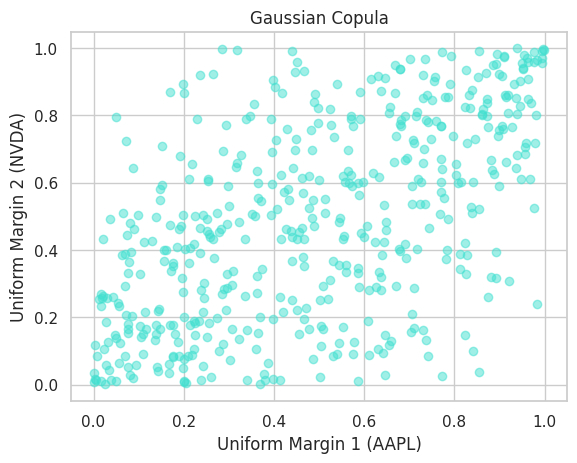

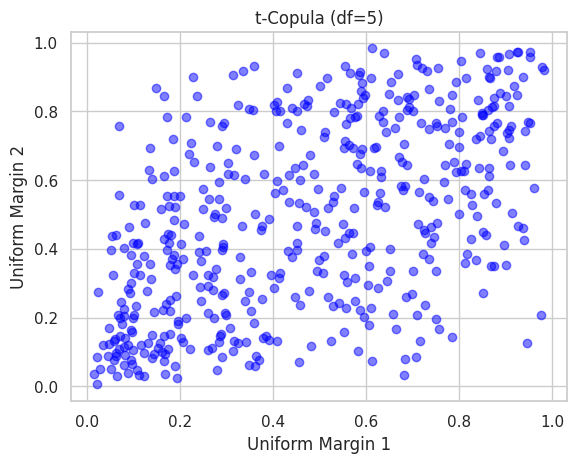

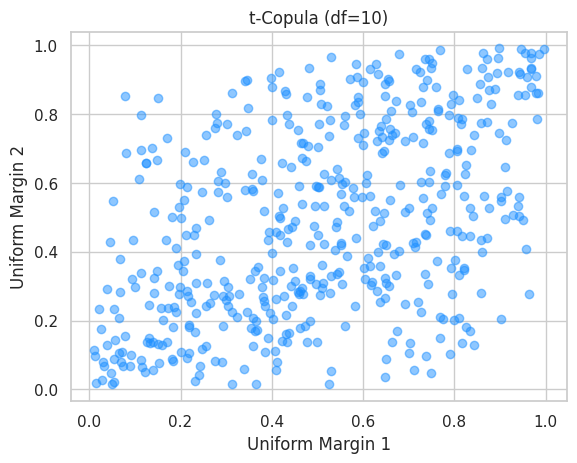

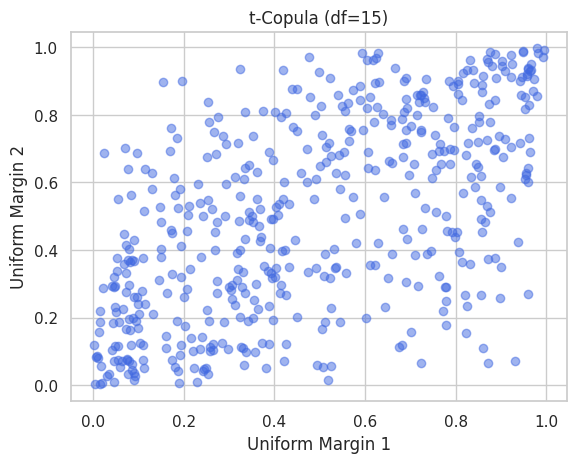

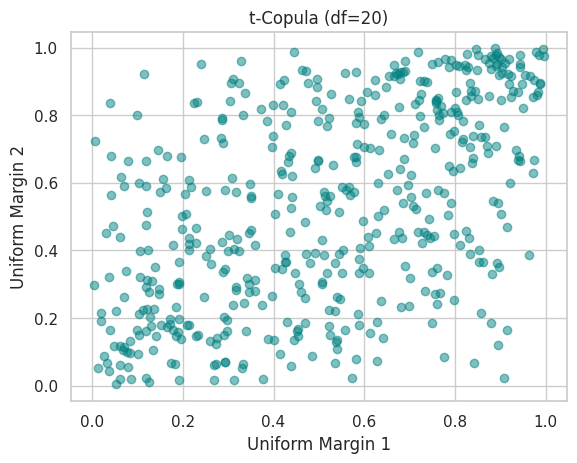

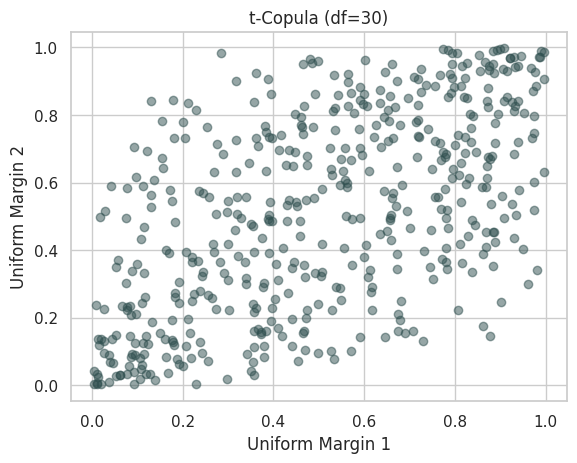

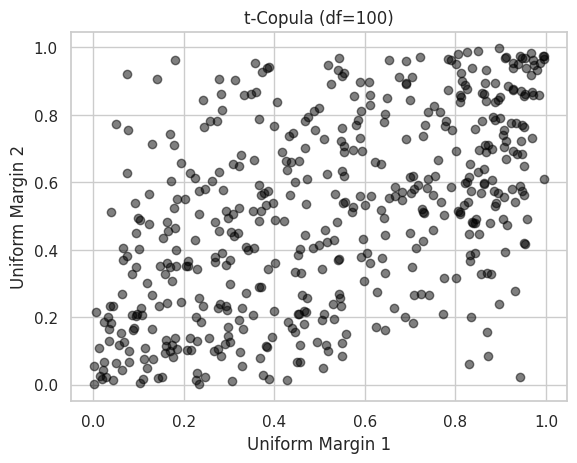

Gaussian Copula: Log-Likelihood = -5239.926695888556
t-Copula (df=5): Log-Likelihood = -6624.723336667463
t-Copula (df=10): Log-Likelihood = -5851.153965778833
t-Copula (df=15): Log-Likelihood = -5630.098709665125
t-Copula (df=20): Log-Likelihood = -5530.5320265438
t-Copula (df=30): Log-Likelihood = -5434.87049917601
t-Copula (df=100): Log-Likelihood = -5299.860972886205


In [59]:
# Standardized residuals
aapl_resid = garch_result_aapl_21.std_resid
nvda_resid = garch_result_nvda_11.std_resid


# Input: Standardized residuals transformed into uniform marginals
u_aapl = norm.cdf(aapl_resid, loc=np.mean(aapl_resid), scale=np.std(aapl_resid))
u_nvda = norm.cdf(nvda_resid, loc=np.mean(nvda_resid), scale=np.std(nvda_resid))

data = np.column_stack((u_aapl, u_nvda))  # Combine into a single dataset
u1, u2 = data[:, 0], data[:, 1]           # Separate into individual components

# Avoid log(0) errors by setting a small epsilon
epsilon = 1e-10

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(u1, u2)

# Gaussian Copula: Calculate Log-Likelihood
gaussian_copula = multivariate_normal(mean=[0, 0], cov=correlation_matrix)
gaussian_density = gaussian_copula.pdf(np.column_stack((norm.ppf(u1), norm.ppf(u2))))
gaussian_density = np.maximum(gaussian_density, epsilon)  # Avoid log(0)
log_likelihood_gaussian = np.sum(np.log(gaussian_density))

# Set seed for reproducibility
np.random.seed(17)

# Generate samples from Gaussian copula - length is same as the test sample
samples_gaussian = gaussian_copula.rvs(size=len(y_test_aapl))
plt.figure()
plt.scatter(norm.cdf(samples_gaussian[:, 0]), norm.cdf(samples_gaussian[:, 1]), alpha=0.5, color='turquoise')
plt.title("Gaussian Copula")
plt.xlabel("Uniform Margin 1 (AAPL)")
plt.ylabel("Uniform Margin 2 (NVDA)")
plt.show()

# t-Copula: Function to calculate and plot for given degrees of freedom
def t_copula_log_likelihood(df, color, title):
    t_density = multivariate_normal(mean=[0, 0], cov=correlation_matrix).pdf(
        np.column_stack((stats.t.ppf(u1, df), stats.t.ppf(u2, df)))
    )
    t_density = np.maximum(t_density, epsilon)  # Avoid log(0)
    log_likelihood = np.sum(np.log(t_density))

    # Generate samples and plot t-Copula
    samples_t = gaussian_copula.rvs(size=len(y_test_aapl))
    plt.figure()
    plt.scatter(t.cdf(samples_t[:, 0], df), t.cdf(samples_t[:, 1], df), alpha=0.5, color=color)
    plt.title(title)
    plt.xlabel("Uniform Margin 1")
    plt.ylabel("Uniform Margin 2")
    plt.show()

    return log_likelihood

# Degrees of Freedom for t-Copulas
log_likelihood_t5 = t_copula_log_likelihood(5, 'blue', "t-Copula (df=5)")
log_likelihood_t10 = t_copula_log_likelihood(10, 'dodgerblue', "t-Copula (df=10)")
log_likelihood_t15 = t_copula_log_likelihood(15, 'royalblue', "t-Copula (df=15)")
log_likelihood_t20 = t_copula_log_likelihood(20, 'teal', "t-Copula (df=20)")
log_likelihood_t30 = t_copula_log_likelihood(30, 'darkslategrey', "t-Copula (df=30)")
log_likelihood_t100 = t_copula_log_likelihood(100, 'black', "t-Copula (df=100)")


# Print Log-Likelihoods for Comparison
print(f"Gaussian Copula: Log-Likelihood = {log_likelihood_gaussian}")
print(f"t-Copula (df=5): Log-Likelihood = {log_likelihood_t5}")
print(f"t-Copula (df=10): Log-Likelihood = {log_likelihood_t10}")
print(f"t-Copula (df=15): Log-Likelihood = {log_likelihood_t15}")
print(f"t-Copula (df=20): Log-Likelihood = {log_likelihood_t20}")
print(f"t-Copula (df=30): Log-Likelihood = {log_likelihood_t30}")
print(f"t-Copula (df=100): Log-Likelihood = {log_likelihood_t100}")


The Gaussian Copula provides the best fit (highest log-likelihood), making it a strong choice for symmetric dependencies with lighter tails.

Lower degrees of freedom t-Copulas are less suitable for this data, as they assume stronger tail behavior than observed. As the degree of freedon increases, the t-copulas converge towards the Gaussian Copula, and the log-likelihood increases, further supporting the choice that the Gaussian Copula is best in this case.

Now that we have determined the Copula to use, we can start forecasting log returns which exhibit the observed dependence.

**Forecasting**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


AAPL MSE: 0.00034893766555401913 AAPL MAE: 0.01446747602615416
NVDA MSE: 0.0012299756528933164 NVDA MAE: 0.02642522780372483
The correlation between AAPL and NVDA forecasts is: 0.5632747299386927


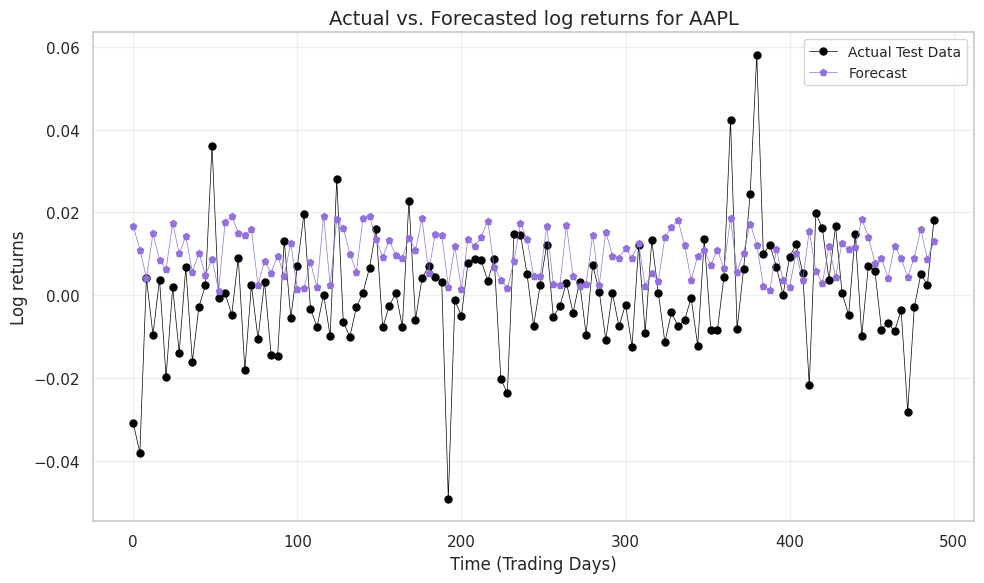

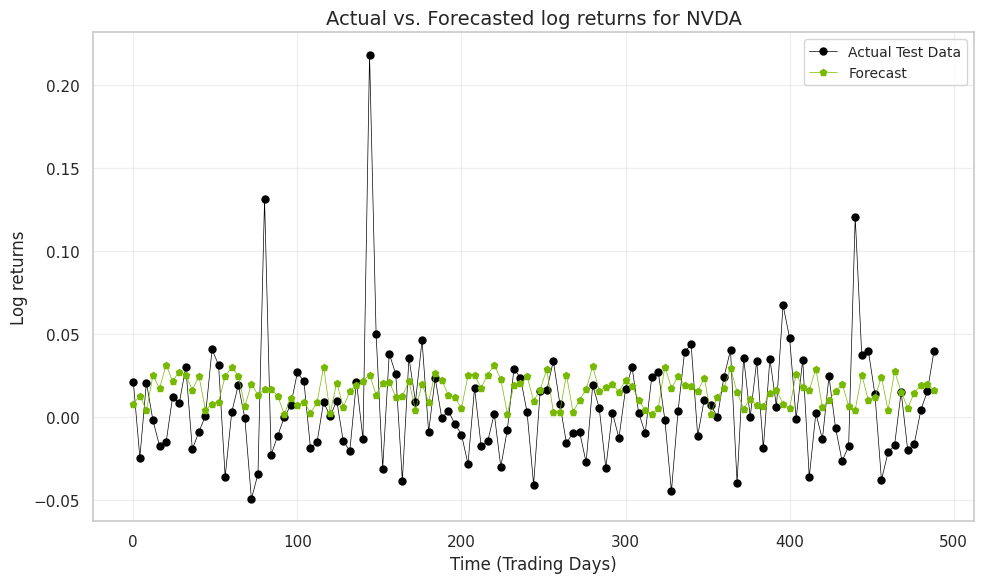

In [61]:
#Transform Guassian draws into uniform draws while preserving the correlation present

samples_uniform = np.column_stack((norm.cdf(samples_gaussian[:, 0]), norm.cdf(samples_gaussian[:, 1])))

# Assign uniform draws to each of AAPL and NVDA
custom_residuals_aapl = samples_uniform[:,0] # Array of standardized residuals
custom_residuals_nvda = samples_uniform[:,1]

# Get ARIMA forecasts
arima_forecast_aapl_correlated = arima_result_aapl_stats.get_forecast(steps=len(y_test_aapl)).predicted_mean
arima_forecast_nvda_correlated = arima_result_nvda_stats_1.get_forecast(steps=len(y_test_nvda)).predicted_mean

# Get GARCH forecasted conditional volatility
garch_conditional_volatility_aapl_correlated = garch_result_aapl_21.forecast(horizon=len(y_test_aapl)).variance.iloc[-len(y_test_aapl):].values.flatten()
garch_conditional_volatility_nvda_correlated = garch_result_nvda_11.forecast(horizon=len(y_test_nvda)).variance.iloc[-len(y_test_nvda):].values.flatten()

# Scale custom residuals by GARCH conditional volatility
scaled_residuals_aapl_correlated = custom_residuals_aapl * np.sqrt(garch_conditional_volatility_aapl_correlated)
scaled_residuals_nvda_correlated = custom_residuals_nvda * np.sqrt(garch_conditional_volatility_nvda_correlated)

# Combine ARIMA and scaled residuals for final forecasts
combined_forecast_aapl_correlated = arima_forecast_aapl_correlated + scaled_residuals_aapl_correlated
combined_forecast_nvda_correlated = arima_forecast_nvda_correlated + scaled_residuals_nvda_correlated

# Evaluate performance
mse_aapl = mean_squared_error(y_test_aapl, combined_forecast_aapl_correlated)
mae_aapl = mean_absolute_error(y_test_aapl, combined_forecast_aapl_correlated)
print("AAPL MSE:", mse_aapl, "AAPL MAE:", mae_aapl)

mse_nvda = mean_squared_error(y_test_nvda, combined_forecast_nvda_correlated)
mae_nvda = mean_absolute_error(y_test_nvda, combined_forecast_nvda_correlated)
print("NVDA MSE:", mse_nvda, "NVDA MAE:", mae_nvda)

correlation = np.corrcoef(combined_forecast_aapl_correlated, combined_forecast_nvda_correlated)[0, 1]
print(f"The correlation between AAPL and NVDA forecasts is: {correlation}")

# Reset indices for alignment
combined_forecast_aapl_cor_reset = combined_forecast_aapl_correlated.reset_index(drop=True)
combined_forecast_aapl_cor_sampled = combined_forecast_aapl_cor_reset[::step]

# Plot the log returns for AAPL
plt.figure(figsize=(10, 6))
plt.plot(y_test_aapl_sampled, label="Actual Test Data", color="black", marker='o', markersize=5, linewidth=0.5)
plt.plot(combined_forecast_aapl_cor_sampled, label="Forecast", color=aapl_bright_color, marker='p', markersize=5, linewidth=0.5)
plt.legend(loc="upper right", fontsize=10)
plt.title("Actual vs. Forecasted log returns for AAPL", fontsize=14)
plt.xlabel("Time (Trading Days)", fontsize=12)
plt.ylabel("Log returns", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Now, create the plot for NVDA, mirroring the AAPL plot:
# Reset indices for alignment
combined_forecast_nvda_cor_reset = combined_forecast_nvda_correlated.reset_index(drop=True)
combined_forecast_nvda_cor_sampled = combined_forecast_nvda_cor_reset[::step]

# Plot the log returns for NVDA
plt.figure(figsize=(10, 6))
plt.plot(y_test_nvda_sampled, label="Actual Test Data", color="black", marker='o', markersize=5, linewidth=0.5)
plt.plot(combined_forecast_nvda_cor_sampled, label="Forecast", color=nvda_logo_color, marker='p', markersize=5, linewidth=0.5) # Using nvda_logo_color
plt.legend(loc="upper right", fontsize=10)
plt.title("Actual vs. Forecasted log returns for NVDA", fontsize=14)
plt.xlabel("Time (Trading Days)", fontsize=12)
plt.ylabel("Log returns", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()








The lower MSE and MAE values for AAPL indicate that the model performs better on AAPL compared to NVDA when for this set of simulations. For both, the simulated returns do not capture the degree of 'extreme' spikes/lows in the actual test data. This is likely for this simualtion only as we observed that for AAPL, the previous 'separate' simulated log-returns did exhibit some degree of extreme log returns. To curtail this, it is best to perform multiple simulations and not just rely on one.

The correlation between AAPL and NVDA of 0.56 is close to that observed for the GARCH residuals (0.50).

We move on to practical applications of the model.

<a id='another_cell6'></a>
<font color='turquoise'><font size='4'>**Practical Applications**</font>


In this section we show a few practical applications of the model namely:
* Forecasting the pathway of a porfolio consisting of NVDA and AAPL shares.
* Measuring its returns and riskiness.
* Determining the optimal mix of NVDA and AAPL shares in the portfolio.

Below we first show how to build the future portfolio value (up to 100 trading days forward) of a portfolio consisting of an equal mix of NVDA and AAPL shares. To keep things simple, we have assumed both shares to be valued at 100 on day 0.

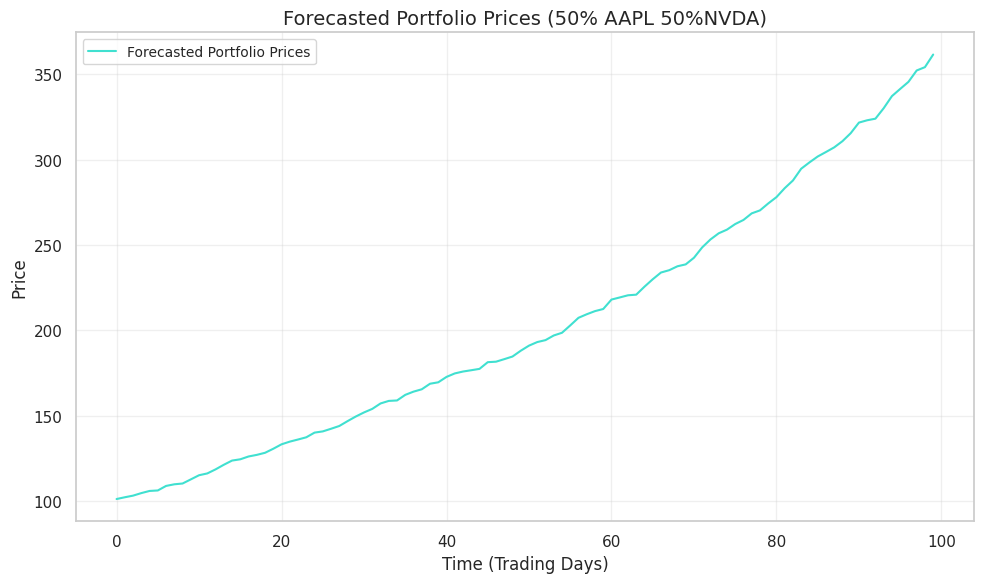

In [62]:
# Assuming initial price of 100 for both AAPL and NVDA
initial_price = 100

# Convert log returns to prices for AAPL
# Here using the cumulative sum, the reverse of the log returns calculation
combined_forecast_aapl_prices = initial_price * np.exp(np.cumsum(combined_forecast_aapl_correlated))

# Convert log returns to prices for NVDA
combined_forecast_nvda_prices = initial_price * np.exp(np.cumsum(combined_forecast_nvda_correlated))


# Create a 50/50 portfolio
portfolio_prices = (combined_forecast_aapl_prices + combined_forecast_nvda_prices) / 2
portfolio_prices_reset = portfolio_prices.reset_index(drop=True)

# Plot the portfolio prices
plt.figure(figsize=(10, 6))
plt.plot(portfolio_prices_reset[:100], label="Forecasted Portfolio Prices", color="turquoise")
plt.legend(loc="upper left", fontsize=10)
plt.title("Forecasted Portfolio Prices (50% AAPL 50%NVDA)", fontsize=14)
plt.xlabel("Time (Trading Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The portfolio value increases over time for this simulation, exceeding 350 in 100 days. This is however only 1 simulation and as previously established, we shouldn't rely on simply 1 observation. Let's increase the number of simulations which creates multiple portfolio value pathways.

In [ ]:
np.random.seed(45)

# Number of simulations
num_simulations = 10000

# Forecast horizon (100 days forward)
forecast_horizon_100 = 100

# Store simulation paths
all_simulations = []

# Simulation loop
for _ in range(num_simulations):
    # Generate correlated random samples (using your Gaussian copula)
    # Limit the size to forecast_horizon
    samples_gaussian_sim = gaussian_copula.rvs(size=forecast_horizon_100)
    samples_uniform_sim = np.column_stack((norm.cdf(samples_gaussian_sim[:, 0]), norm.cdf(samples_gaussian_sim[:, 1])))

    # AAPL and NVDA residuals (using inverse transform sampling)
    predicted_et_aapl_sim = norm.ppf(samples_uniform_sim[:, 0], loc=np.mean(garch_result_aapl_21.std_resid), scale=np.std(garch_result_aapl_21.std_resid)).flatten()
    predicted_et_nvda_sim = norm.ppf(samples_uniform_sim[:, 1], loc=np.mean(garch_result_nvda_11.std_resid), scale=np.std(garch_result_nvda_11.std_resid)).flatten()

    # Get ARIMA and GARCH forecasts for the forecast horizon
    arima_forecast_aapl_sim = arima_result_aapl_stats.get_forecast(steps=forecast_horizon_100).predicted_mean
    arima_forecast_nvda_sim = arima_result_nvda_stats_1.get_forecast(steps=forecast_horizon_100).predicted_mean
    garch_conditional_volatility_aapl_sim = garch_result_aapl_21.forecast(horizon=forecast_horizon_100).variance.iloc[-forecast_horizon_100:].values.flatten()
    garch_conditional_volatility_nvda_sim = garch_result_nvda_11.forecast(horizon=forecast_horizon_100).variance.iloc[-forecast_horizon_100:].values.flatten()

    # Predictions for AAPL and NVDA prices for the forecast horizon
    prices_aapl_sim = initial_price * np.exp(np.cumsum(arima_forecast_aapl_sim.values + predicted_et_aapl_sim * np.sqrt(garch_conditional_volatility_aapl_sim)))
    prices_nvda_sim = initial_price * np.exp(np.cumsum(arima_forecast_nvda_sim.values + predicted_et_nvda_sim * np.sqrt(garch_conditional_volatility_nvda_sim)))

    # Create portfolio and store path
    portfolio_sim = (prices_aapl_sim + prices_nvda_sim) / 2
    all_simulations.append(portfolio_sim);

<ipython-input-105-85e737d417e3>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", fontsize=10)


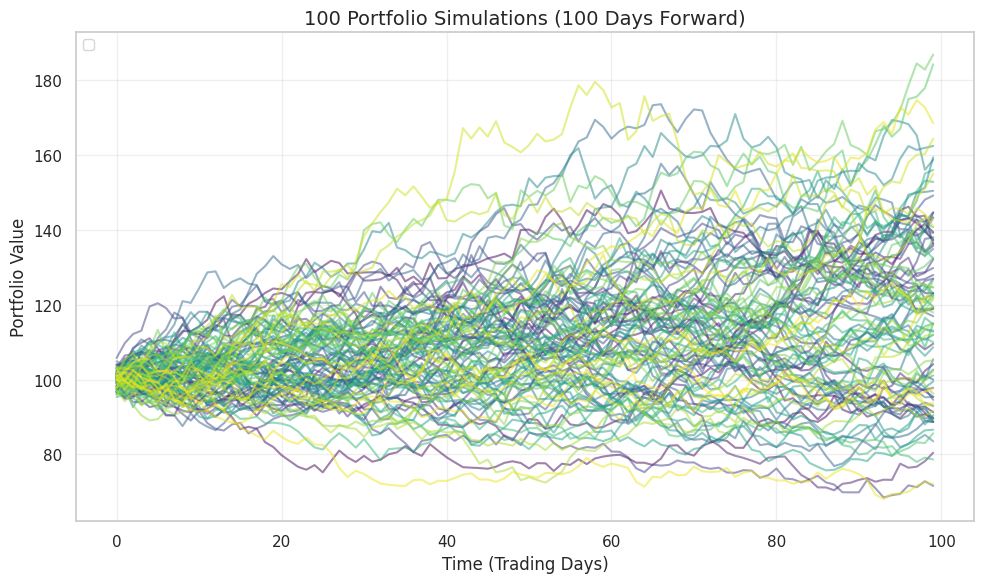

In [105]:
plt.figure(figsize=(10, 6))

# Number of simulations to plot
# Better visibility than all 10,000
num_simulations_to_plot = 100

# Generate a colormap with num_simulations_to_plot colors
colors = cm.viridis(np.linspace(0, 1, num_simulations_to_plot))

# Plot a subset of simulations with unique colors
for i in range(num_simulations_to_plot):
    plt.plot(all_simulations[i], color=colors[i], alpha=0.5)

# Plot actual portfolio prices (for comparison, if available)
plt.title('100 Portfolio Simulations (100 Days Forward)', fontsize=14)
plt.xlabel('Time (Trading Days)', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The above plot some of the multiple pathways the portfolio can take. From this, we can infer the distribution of the portfolio value in 100 days or at an earlier time.

<font size='4'>**Risk-return profile**</font>

In [106]:
terminal_values = [sim[-1] for sim in all_simulations]
mean_terminal_value = np.mean(terminal_values)
std_terminal_value = np.std(terminal_values)
print(f"Mean Terminal Portfolio Value: {mean_terminal_value:.2f}")
print(f"Std Dev of Terminal Value: {std_terminal_value:.2f}")

Mean Terminal Portfolio Value: 118.98
Std Dev of Terminal Value: 26.29


In 100 days, the portfolio has an expected value of 118.98 with a standard deviation of 26.29. This gives a view of the risk-return profile of the portfolio. We can equally, gauge the downside risk of the portfolio using the Value-at-Risk.

Value at Risk (VaR) is a widely used risk management measure that quantifies the potential loss in value of a portfolio or investment over a specified time period, given a certain level of confidence.

Very breifly, it incorporates the following three elments:
* Time Horizon: The period over which the risk is assessed (here, 100 days).
* Confidence Level: The probability that the actual value will not exceed the VaR (e.g., 95%, 99% confidence).
* Loss Amount: The potential decline in value under normal market conditions.





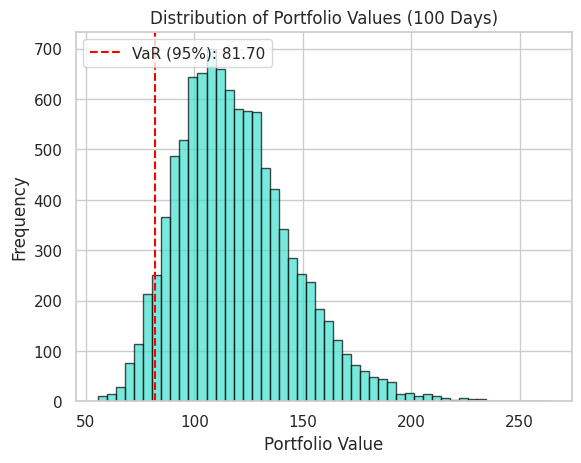

In [107]:
# Calculate VaR at 5% confidence level
confidence_level = 0.05  # 5% quantile
var_value = np.percentile(terminal_values, 100 * confidence_level)

# Plot the histogram
plt.hist(terminal_values, bins=50, alpha=0.7, color="turquoise", edgecolor='black')
plt.axvline(var_value, color='red', linestyle='--', linewidth=1.5, label=f"VaR (95%): {var_value:.2f}")
plt.title("Distribution of Portfolio Values (100 Days)")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.show()

We can interpret the VaR here as: 95% of the time, we do not expect the value to fall beneath 81.70 after 100 days.

<font size='4'>**Portfolio Optimisation**</font>

We can optimise the risk-return profile of the portfolio by allocating different weights to NVDA and AAPL in the portfolio.

In [ ]:
np.random.seed(45)

# Number of simulations
num_simulations = 10000

# Forecast horizon (100 days forward)
forecast_horizon_100 = 100

# Store simulation paths for different weights
results = []

# Define weights for NVDA and AAPL
weights = np.linspace(0, 1, 5)  # Range of weights: [0.0, 0.1, ..., 1.0]

# Simulation loop across weights
for w_nvda in weights:
    w_aapl = 1 - w_nvda  # Complementary weight

    all_simulations = []

    # Simulation loop for 10000 simulations
    for _ in range(num_simulations):
        # Generate correlated random samples using Gaussian Copula
        samples_gaussian_sim = gaussian_copula.rvs(size=forecast_horizon_100)
        samples_uniform_sim = np.column_stack((norm.cdf(samples_gaussian_sim[:, 0]), norm.cdf(samples_gaussian_sim[:, 1])))

        # Residuals for AAPL and NVDA
        predicted_et_aapl_sim = norm.ppf(samples_uniform_sim[:, 0], loc=np.mean(garch_result_aapl_21.std_resid), scale=np.std(garch_result_aapl_21.std_resid)).flatten()
        predicted_et_nvda_sim = norm.ppf(samples_uniform_sim[:, 1], loc=np.mean(garch_result_nvda_11.std_resid), scale=np.std(garch_result_nvda_11.std_resid)).flatten()

        # ARIMA and GARCH forecasts
        arima_forecast_aapl_sim = arima_result_aapl_stats.get_forecast(steps=forecast_horizon_100).predicted_mean
        arima_forecast_nvda_sim = arima_result_nvda_stats_1.get_forecast(steps=forecast_horizon_100).predicted_mean
        garch_conditional_volatility_aapl_sim = garch_result_aapl_21.forecast(horizon=forecast_horizon_100).variance.iloc[-forecast_horizon_100:].values.flatten()
        garch_conditional_volatility_nvda_sim = garch_result_nvda_11.forecast(horizon=forecast_horizon_100).variance.iloc[-forecast_horizon_100:].values.flatten()

        # Predictions for AAPL and NVDA prices
        prices_aapl_sim = initial_price * np.exp(np.cumsum(arima_forecast_aapl_sim.values + predicted_et_aapl_sim * np.sqrt(garch_conditional_volatility_aapl_sim)))
        prices_nvda_sim = initial_price * np.exp(np.cumsum(arima_forecast_nvda_sim.values + predicted_et_nvda_sim * np.sqrt(garch_conditional_volatility_nvda_sim)))

        # Portfolio values for given weights
        portfolio_sim = w_nvda * prices_nvda_sim + w_aapl * prices_aapl_sim
        all_simulations.append(portfolio_sim)

    # Extract terminal portfolio values
    terminal_values = [sim[-1] for sim in all_simulations]

    # Calculate metrics
    mean_terminal_value = np.mean(terminal_values)
    std_terminal_value = np.std(terminal_values)
    var_value = np.percentile(terminal_values, 5)  # Value at Risk (95% confidence)

    # Store results
    results.append({
        "NVDA Weight": w_nvda,
        "AAPL Weight": w_aapl,
        "Mean Terminal Value": mean_terminal_value,
        "Std Deviation": std_terminal_value,
        "VaR (95%)": var_value
    })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

In [109]:
# Display results
print(results_df)

   NVDA Weight  AAPL Weight  Mean Terminal Value  Std Deviation  VaR (95%)
0         0.00         1.00           112.430275      21.142873  81.451126
1         0.25         0.75           115.350435      22.484559  82.803080
2         0.50         0.50           119.161186      26.240793  82.000956
3         0.75         0.25           121.377419      31.492584  77.611561
4         1.00         0.00           125.563783      38.040690  73.599606


The **mean terminal value** increases as the portfolio allocation shifts toward NVDA. This indicates that NVDA offers higher average returns compared to AAPL over the 100-day horizon:
* Mean for full allocation to AAPL (NVDA Weight = 0.00): 112.43
* Mean for full allocation to NVDA (NVDA Weight = 1.00): 125.56

Risk (as measured by **standard deviation**) increases as NVDA weight increases. NVDA introduces higher variability in portfolio outcomes compared to AAPL:
* Standard deviation for Full allocation to AAPL: 21.14
* Standard devaition for full allocation to NVDA: 38.04

The **VaR (95%)** decreases as NVDA's weight increases, reflecting more downside risk for AAPL-heavy portfolios. At full allocation to NVDA, the portfolio's worst-case loss scenario at that confidence level has a terminal value of 73.60, compared to 81.45 for AAPL.

While NVDA provides higher returns, it also introduces increased tail risk, as seen in the significant drop in VaR.

A balanced portfolio (50-50 split) offers a compromise between risk and return, providing a mean terminal value of 119.16 with moderate standard deviation (26.24).

Investors with a higher risk tolerance might favor a heavier allocation to NVDA for higher returns, despite the increased volatility and lower VaR.

<a id='another_cell7'></a>
<font color='turquoise'><font size='4'>**Conclusion**</font>

This notebook demonstrates the forecasting of portfolio risk and performance using a blend of statistical techniques tailored to financial data. By leveraging ARIMA models for trend and seasonality analysis, GARCH models for capturing volatility clustering, and Copulas for modeling dependencies between assets, we established a robust framework for understanding and managing portfolio dynamics.

Through practical applications, we analyzed a portfolio composed of Apple Inc. and Nvidia Corporation, showcasing how these methods can predict future asset behaviors, optimise weight allocations, and quantify risks like Value-at-Risk (VaR). This blend of tools not only provides insights into individual asset behavior but also reveals the interconnectedness crucial for portfolio management.

As financial markets continue to evolve, the combination of these models offers a dynamic and adaptive approach to risk forecasting and decision-making. The project highlighted the importance of combining statistical rigor with practical applications, paving the way for more informed investment strategies and robust risk management practices.

<a id='another_cell8'></a>
<font color='turquoise'><font size='4'>**References**</font>

**Copula/Dependence Structure literature**
* Nelsen, R. (1999). An introduction to copulas. New York: Springer
*  McNeil, A., Frey, R. and Embrechts, P. (2005). Quantitative risk management.
 Princeton, N.J. : Princeton University Press.

**Excel formulae references**
* https://computing.net/office/how-to-find-the-last-monday-of-the-month-in-excel/#:~:text=The%20EOMONTH%20function%20is%20a,latest%20day%20of%20a%20month.
* https://www.statology.org/excel-first-monday-of-month/

**GARCH literature**
*  Engle, R. and Mezrich, J. (1996). GARCH for Groups. Risk, 9(8), pp.36-40.
*  Engle, R. and Patton, A. (2001). What good is a volatility model?. Quantitative
 Finance, 1(2), pp.237-245.
*  Campbell, J., Lo, A., MacKinlay, A. and Whitelaw, R. (1998). The econometrics of
 f
 inancial markets. Macroeconomics. Dynamics., 2(4), pp.559-562.

**Jarque-Bera Test**
 * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html

**Research on share prices/news**
* https://www.fool.com/investing/2016/12/09/why-nvidia-corporation-stock-skyrocketed-296-in-no.aspx
* https://www.oyez.org/cases/2024/23-970#:~:text=However%2C%20the%20company's%20executives%2C%20particularly,did%20so%20knowingly%20or%20recklessly.

**Sktime documentation**
* https://www.sktime.net/en/stable/examples.html

**Copulas**
* Sklar, A., 1959. Fonctions de Répartition à n Dimensions et Leurs Marges. Publications de l'Institut de Statistique de l'Université de Paris, 8, pp.229-231.
* https://copulae.readthedocs.io/en/latest/api_reference/copulae/elliptical/index.html





